<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Jerry Sun, Peter Wu, Shihao Cao (js2746, plw53, sfc72)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

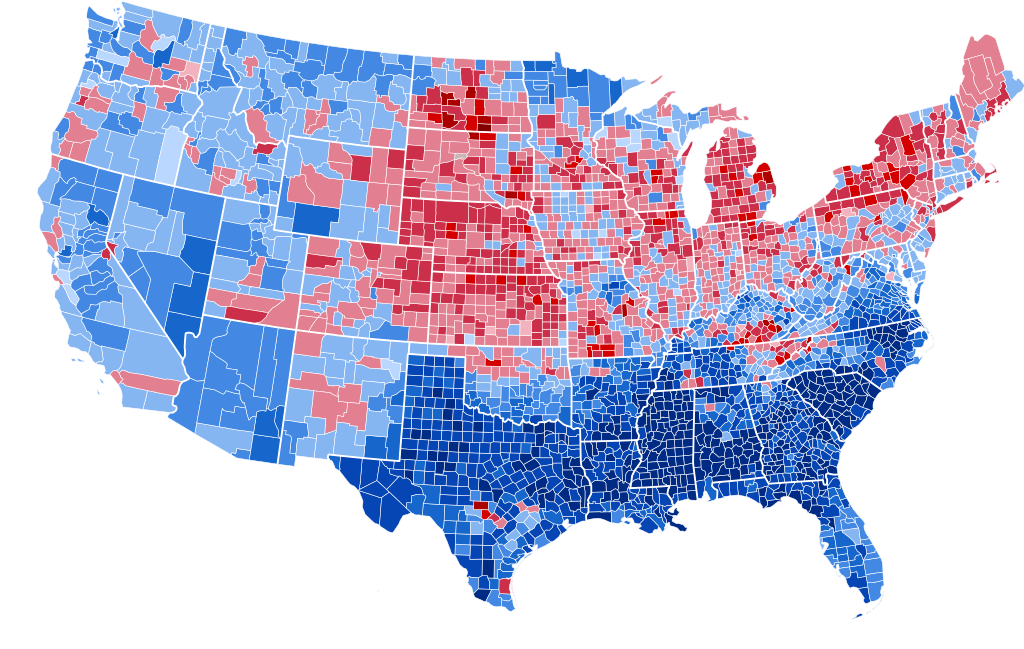

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Split train and validation sets of the train data
from sklearn.neighbors import KNeighborsClassifier # Import KNN model for first basic solution
from sklearn import svm # Import SVM since it's good at predicting binary labels - second basic solution
from sklearn.model_selection import cross_val_score # uses K-fold cross-val by default.
from sklearn.metrics import make_scorer # Import scorer for use in cross-validation scoring (weighted accuracy)
import warnings
warnings.filterwarnings('ignore')
# TODO: Tensorflow imports later

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [48]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    
    d_err = num_pos - num_pos_correct
    r_err = num_neg - num_neg_correct
    print(f"D ERR: {d_err}; R ERR: {r_err} on total: {num_labels}")
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. Here is SVM, 
Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [9]:
# You may change this but we suggest loading data with the following code and you may need to change
# datatypes and do necessary data transformation after loading the raw data to the dataframe.
# df = pd.read_csv(dataset_path, sep=',',header=None, encoding='unicode_escape')

# Make sure you comment your code clearly and you may refer to these comments in the part 2.4

def preprocess(df):    
    
    # Binary Indicator of Dem or Gop winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0

#         d = float(df['DEM'][x])
#         r = df['GOP'][x]
#         total_pop = d + r
#         mult = 1
#         if d > r:
#             mult = 1
#         df['Winner'][x] =mult*d/total_pop
   
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
        #mean = np.mean(np.array(df[col]))
        #std = np.std(np.array(df[col]))
        #df[col] = (df[col] - mean)/std
    return df

def test_preprocess(df):
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
#         mean = np.mean(np.array(df[col]))
#         std = np.std(np.array(df[col]))
#         df[col] = (df[col] - mean)/std
    return df

def package(preds, df):
    df['Result'][0:] = preds.astype(int)
    return df

In [10]:
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = preprocess(rawdf16.copy())
df16


FIPS                  County    DEM    GOP  MedianIncome  MigraRate  \
0     18019        Clark County, IN  18791  30012      0.385093   0.094595   
1      6035       Lassen County, CA   2026   6533      0.369908  -0.355212   
2     40081      Lincoln County, OK   2423  10838      0.333663  -0.025097   
3     31153        Sarpy County, NE  27704  44649      0.552519   0.177606   
4     28055    Issaquena County, MS    395    298      0.200261  -0.247104   
...     ...                     ...    ...    ...           ...        ...   
1550  36009  Cattaraugus County, NY   8717  18668      0.343395  -0.067568   
1551  55031      Douglas County, WI  11342   9657      0.373972  -0.050193   
1552  27065      Kanabec County, MN   2327   5230      0.381453   0.030888   
1553  17139     Moultrie County, IL   1476   4453      0.426769  -0.177606   
1554  20185     Stafford County, KS    303   1485      0.342503  -0.152510   

      BirthRate  DeathRate  BachelorRate  UnemploymentRate  Winner  
0      0.439863   0.384615      0.280161          0.174274       0  
1      0.316151   0.220280      0.160858          0.286307       0  
2      0.391753   0.409091      0.202413          0.219917       0  
3      0.487973   0.174825      0.537534          0.120332       0  
4      0.336770   0.185315      0.089812          0.580913       1  
...         ...        ...           ...               ...     ...  
1550   0.384880   0.377622      0.256032          0.248963       0  
1551   0.336770   0.356643      0.321716          0.215768       1  
1552   0.347079   0.363636      0.195710          0.269710       0  
1553   0.443299   0.454545      0.261394          0.190871       0  
1554   0.443299   0.423077      0.320375          0.153527       0  

[1555 rows x 11 columns]

In [11]:
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = preprocess(rawdf12.copy())
df12


FIPS                  County    DEM    GOP  MedianIncome  MigraRate  \
0     18019        Clark County, IN  20775  25422      0.413372   0.000832   
1      6035       Lassen County, CA   3044   7261      0.399213  -0.164725   
2     40081      Lincoln County, OK   3265   9542      0.371206  -0.023295   
3     31153        Sarpy County, NE  24709  40318      0.572738   0.066556   
4     28055    Issaquena County, MS    479    302      0.242874   0.018303   
...     ...                     ...    ...    ...           ...        ...   
1550  36009  Cattaraugus County, NY  11695  15406      0.360048  -0.062396   
1551  55031      Douglas County, WI  14855   7698      0.366363  -0.054077   
1552  27065      Kanabec County, MN   3586   4319      0.371879  -0.122296   
1553  17139     Moultrie County, IL   2142   3781      0.427624   0.006656   
1554  20185     Stafford County, KS    403   1382      0.363563  -0.038270   

      BirthRate  DeathRate  BachelorRate  UnemploymentRate  Winner  
0      0.458042   0.431111      0.273611          0.284672       0  
1      0.314685   0.355556      0.179167          0.456204       0  
2      0.395105   0.493333      0.181944          0.182482       0  
3      0.555944   0.217778      0.508333          0.142336       0  
4      0.300699   0.320000      0.108333          0.642336       1  
...         ...        ...           ...               ...     ...  
1550   0.409091   0.448889      0.250000          0.339416       0  
1551   0.384615   0.404444      0.304167          0.251825       1  
1552   0.248252   0.364444      0.186111          0.328467       0  
1553   0.430070   0.528889      0.215278          0.259124       0  
1554   0.360140   0.568889      0.281944          0.167883       0  

[1555 rows x 11 columns]

In [12]:
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfgraph


SRC    DST
0       1001   1001
1       1001   1021
2       1001   1047
3       1001   1051
4       1001   1085
...      ...    ...
12712  72153  72153
12713  78010  78010
12714  78020  78020
12715  78020  78030
12716  78030  78030

[12717 rows x 2 columns]

In [13]:
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
dfsample

FIPS  Result
0     17059       0
1      6103       0
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       0
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]

In [14]:
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16.copy())
test16


FIPS                 County  MedianIncome  MigraRate  BirthRate  \
0     17059    Gallatin County, IL      0.335782  -0.050548   0.378947   
1      6103      Tehama County, CA      0.343839   0.008584   0.449123   
2     42047         Elk County, PA      0.417452  -0.044349   0.340351   
3     47147   Robertson County, TN      0.495506   0.035289   0.445614   
4     39039    Defiance County, OH      0.442326  -0.025274   0.389474   
...     ...                    ...           ...        ...        ...   
1550  55095        Polk County, WI      0.454619   0.006676   0.333333   
1551  34035    Somerset County, NJ      0.886754  -0.009061   0.354386   
1552  42107  Schuylkill County, PA      0.426136  -0.000477   0.326316   
1553  48293   Limestone County, TX      0.333647   0.002384   0.463158   
1554  37087     Haywood County, NC      0.383700   0.071531   0.354386   

      DeathRate  BachelorRate  UnemploymentRate  
0      0.363372      0.126115          0.381910  
1      0.302326      0.197452          0.356784  
2      0.377907      0.236943          0.276382  
3      0.281977      0.236943          0.206030  
4      0.296512      0.212739          0.246231  
...         ...           ...               ...  
1550   0.313953      0.259873          0.231156  
1551   0.209302      0.694268          0.206030  
1552   0.389535      0.206369          0.311558  
1553   0.328488      0.178344          0.281407  
1554   0.366279      0.318471          0.226131  

[1555 rows x 8 columns]

In [15]:
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12.copy())
test12

FIPS                 County  MedianIncome  MigraRate  BirthRate  \
0     17059    Gallatin County, IL      0.314441  -0.128660   0.299003   
1      6103      Tehama County, CA      0.318161  -0.031056   0.378738   
2     42047         Elk County, PA      0.401674  -0.026619   0.322259   
3     47147   Robertson County, TN      0.445897  -0.039929   0.475083   
4     39039    Defiance County, OH      0.382532  -0.057675   0.385382   
...     ...                    ...           ...        ...        ...   
1550  55095        Polk County, WI      0.412586  -0.099379   0.318937   
1551  34035    Somerset County, NJ      0.788239   0.000000   0.345515   
1552  42107  Schuylkill County, PA      0.366433   0.007098   0.328904   
1553  48293   Limestone County, TX      0.300998   0.011535   0.451827   
1554  37087     Haywood County, NC      0.330078   0.007098   0.328904   

      DeathRate  BachelorRate  UnemploymentRate  
0      0.570796      0.142477          0.351464  
1      0.420354      0.187750          0.573222  
2      0.548673      0.205060          0.292887  
3      0.415929      0.225033          0.292887  
4      0.433628      0.217044          0.322176  
...         ...           ...               ...  
1550   0.371681      0.255659          0.334728  
1551   0.300885      0.692410          0.309623  
1552   0.584071      0.198402          0.405858  
1553   0.469027      0.181092          0.288703  
1554   0.526549      0.316911          0.380753  

[1555 rows x 8 columns]

<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [16]:
# Basic Model 1 - K-Nearest Neighbors

def knn_classifier(k_grid, distance_metrics, train_x, train_y):
    '''Returns KNN parameters for classifying county election results.

    Args: 
      k_grid: interval for grid searching number of neighbors
      distance_metrics: array of distance metric strings for the K-nearest neighbor classifier
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, 0, 'euclidean']
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    
    # Grid search with cross-validation
    for metric in distance_metrics:
        for k in k_grid:
            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_val_score(knn_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                    best[0], best[1], best[2] = np.mean(scores), k, metric
    return best


In [17]:
# Basic Model 2 - SVM. 
def train_SVM(c_grid, g_grid, train_x, train_y):
    '''Trains an SVM using scikit-learn by conducting a grid search and cross-validation
       to find optimal hyperparameter values based on given intervals.
       
    Args: 
      c_grid: interval for grid searching C values
      g_grid: interval for grid searching gamma values
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, -1, -1]
    # Grid search with cross-validation.
    for c in c_grid:
        for g in g_grid:
            # We suspect the data to be nonlinear and RBF is a consistent choice for this purpose.
            svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
            scores = cross_val_score(svm_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                best[0], best[1], best[2] = np.mean(scores), c, g
    return best

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [18]:
# Partition data into train for features and labels, and test labels for predictions
train_x = np.array(df16.iloc[0:,4:10])
train_y = np.array(df16.iloc[0:,10])
test_x = np.array(test16.iloc[0:,2:])

In [19]:
# K-Nearest Neighbors algorithm

# Grid search using these grids in the KNN model. For use with cross-validation.
ks = range(1, 6, 1)
distance_metrics = ['minkowski', 'manhattan', 'chebyshev', 'euclidean', 'seuclidean']

best = knn_classifier(ks, distance_metrics, train_x, train_y)

print(best)
knn_model = KNeighborsClassifier(n_neighbors=best[1], metric=best[2])
knn_model.fit(train_x, train_y)
preds_knn = knn_model.predict(test_x)

[0.8294589416858154, 2, 'minkowski']


In [20]:
# SVM algorithm with 10-fold cross validation + grid search to find good hyperparameters.

# Grid search using these intervals for C and gamma in the SVM model. For use with cross-validation.
cs = (2.0**np.linspace(5,11,10))
gammas = (np.linspace(0.5,7,10))

best = train_SVM(cs, gammas, train_x, train_y)

print(best)
svm_model = svm.SVC(kernel='rbf', C=best[1], gamma=best[2])
svm_model.fit(train_x, train_y)
preds_svm = svm_model.predict(test_x)

KeyboardInterrupt: 

In [ ]:
# Package predictions for both basic models into a csv for submission

submission_knn = package(preds_knn, dfsample.copy())
submission_svm = package(preds_svm, dfsample.copy())

submission_knn.to_csv('submission_knn.csv',index = False)
submission_svm.to_csv('submission_svm.csv',index = False)
submiss_knn = pd.read_csv('submission_knn.csv', sep=',', encoding='unicode_escape')
series_knn = submiss_knn['Result'].value_counts()
submiss_svm = pd.read_csv('submission_svm.csv', sep=',', encoding='unicode_escape')
series_svm = submiss_svm['Result'].value_counts()

print(series_knn) 
print(series_svm)

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)

Yes. Here is a screenshot of both our submission scores for KNN and SVM solutions (both >68% performance)

![kaggle_basic_screenshot](https://i.imgur.com/FMY2qjZ.png)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [21]:
# Make sure you comment your code clearly and you may refer to these comments in the part 3.2
# Feature Engineering TODO: 
# graph data get % of neighbors voting D in 2012,
# Model TODO: regularization like https://medium.com/datadriveninvestor/a-simple-way-to-know-how-important-your-input-is-in-neural-network-86cbae0d3689 or/and https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ 
# TODO 

### 3.1.1 Import Statements

In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Split train and validation sets of the train data
from sklearn import svm # Baseline Model SVM since it's good at predicting binary labels
from sklearn.model_selection import cross_val_score # uses K-fold cross-val by default.
from sklearn.metrics import make_scorer # Import scorer for use in cross-validation scoring (weighted accuracy)
# TODO: Tensorflow imports later

import tensorflow as tf
tf.random.set_seed(123)

from IPython.display import clear_output
from matplotlib import pyplot as plt


### 3.1.1.1 Import Statements Pre + Post Processing Setup


In [224]:
def gen_class_weights(df):
    df['Weight'] = 0.0
    d_weight = 5.0
    r_weight = 1.0
    for x in range(0, len(df)):    
        if df['Winner'][x] == 1:
            df['Weight'][x] = d_weight
        else:
            df['Weight'][x] = r_weight
       
    return df

def gen_labels(df):
    # Binary Indicator of Dem or Gop winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0
       
    return df

def norm_preprocess(df):    
   
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
        #mean = np.mean(np.array(df[col]))
        #std = np.std(np.array(df[col]))
        #df[col] = (df[col] - mean)/std
    return df

def ratio_preprocess(df):    
    df['Winner'] = 0.0
    for x in range(0, len(df)):    
        d = float(df['DEM'][x])
        r = df['GOP'][x]
        total_pop = d + r
        mult = 1
        if d > r:
            mult = 1
        df['Winner'][x] =mult*d/total_pop
    return df

def cthresh(preds, thresh=0.5):
#     print(preds)
    preds = (preds > thresh).astype(int)
    return preds

def cpackage(preds, df, thresh = 0.5):
    df['Result'][0:] = (preds > thresh).astype(int)
    return df

### 3.1.1.2 Data Setup



In [225]:
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = ratio_preprocess(rawdf16)

rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = ratio_preprocess(rawdf12)

dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')

dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')

rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16)

rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12)

### 3.1.2 Feature Engineering

In [226]:
def cpreprocess(d16, d12, graph, test=False, ratio = False):
    # Preprocess raw dataframes
    creative = norm_preprocess(d16.copy())

    # Set up the Hot Encode Categorical State Column for Tensorflow to do it for us :)
    states = []
    for row in range(len(creative)):
        states.append(creative['County'][row][-2:])
    creative['StateCode'] = np.array(states)
    # Incorporate 2012->2016 changes in data and Standard Normalize them
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for cols in norm_cols:
#         delta = np.array(d16[cols]) - np.array(d12[cols])
        delta = np.array(d12[cols])
        #mean = np.mean(delta)
        #std = np.std(delta)
        name = cols + '2012'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
        
    for cols in norm_cols:
        delta = np.array(d16[cols]) - np.array(d12[cols])
#         delta = np.array(d12[cols])
        #mean = np.mean(delta)
        #std = np.std(delta)
        name = cols + 'Diff'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
                
        
    if not test:
        if ratio:
            creative = ratio_preprocess(creative)
        else:
            creative = gen_labels(creative)
            creative = creative.astype({'Winner': 'int64'})
        
        # GENEREATE CLASS WEIGHTS
        creative = gen_class_weights(creative)
        
        # get a list of the columns
        col_list = list(creative.columns)
        w_idx = col_list.index('Winner')
        del col_list[w_idx]
        col_list.append('Winner')

    #     data_top = creative.columns 
    #     print(data_top)
    #     last_col_name = data_top[-1]
    #     swap_names = ['Winner',last_col_name]
        creative = creative.reindex(columns=col_list)
        print(creative.dtypes)
    return creative
traindf = cpreprocess(rawdf16, rawdf12, dfgraph, ratio = False)
testdf = cpreprocess(rawtest16, rawtest12, dfgraph, test = True)
traindf

FIPS                      int64
County                   object
DEM                       int64
GOP                       int64
MedianIncome            float64
MigraRate               float64
BirthRate               float64
DeathRate               float64
BachelorRate            float64
UnemploymentRate        float64
StateCode                object
MedianIncome2012        float64
MigraRate2012           float64
BirthRate2012           float64
DeathRate2012           float64
BachelorRate2012        float64
UnemploymentRate2012    float64
MedianIncomeDiff        float64
MigraRateDiff           float64
BirthRateDiff           float64
DeathRateDiff           float64
BachelorRateDiff        float64
UnemploymentRateDiff    float64
Weight                  float64
Winner                    int64
dtype: object


FIPS                  County    DEM    GOP  MedianIncome  MigraRate  \
0     18019        Clark County, IN  18791  30012      0.385093   0.094595   
1      6035       Lassen County, CA   2026   6533      0.369908  -0.355212   
2     40081      Lincoln County, OK   2423  10838      0.333663  -0.025097   
3     31153        Sarpy County, NE  27704  44649      0.552519   0.177606   
4     28055    Issaquena County, MS    395    298      0.200261  -0.247104   
...     ...                     ...    ...    ...           ...        ...   
1550  36009  Cattaraugus County, NY   8717  18668      0.343395  -0.067568   
1551  55031      Douglas County, WI  11342   9657      0.373972  -0.050193   
1552  27065      Kanabec County, MN   2327   5230      0.381453   0.030888   
1553  17139     Moultrie County, IL   1476   4453      0.426769  -0.177606   
1554  20185     Stafford County, KS    303   1485      0.342503  -0.152510   

      BirthRate  DeathRate  BachelorRate  UnemploymentRate  ...  \
0      0.439863   0.384615      0.280161          0.174274  ...   
1      0.316151   0.220280      0.160858          0.286307  ...   
2      0.391753   0.409091      0.202413          0.219917  ...   
3      0.487973   0.174825      0.537534          0.120332  ...   
4      0.336770   0.185315      0.089812          0.580913  ...   
...         ...        ...           ...               ...  ...   
1550   0.384880   0.377622      0.256032          0.248963  ...   
1551   0.336770   0.356643      0.321716          0.215768  ...   
1552   0.347079   0.363636      0.195710          0.269710  ...   
1553   0.443299   0.454545      0.261394          0.190871  ...   
1554   0.443299   0.423077      0.320375          0.153527  ...   

     BachelorRate2012  UnemploymentRate2012  MedianIncomeDiff  MigraRateDiff  \
0            0.273611              0.284672          0.116587       0.073282   
1            0.179167              0.456204          0.100885       0.021374   
2            0.181944              0.182482          0.033367       0.022901   
3            0.508333              0.142336          0.272866       0.018321   
4            0.108333              0.642336         -0.084137      -0.229008   
...               ...                   ...               ...            ...   
1550         0.250000              0.339416          0.148384       0.061069   
1551         0.304167              0.251825          0.295154       0.059542   
1552         0.186111              0.328467          0.310464       0.248855   
1553         0.215278              0.259124          0.287347      -0.152672   
1554         0.281944              0.167883          0.124918      -0.050382   

      BirthRateDiff  DeathRateDiff  BachelorRateDiff  UnemploymentRateDiff  \
0         -0.032967       0.110169          0.063492             -0.734694   
1          0.021978      -0.144068         -0.047619             -1.142857   
2          0.010989       0.050847          0.105820              0.061224   
3         -0.186813       0.008475          0.185185             -0.204082   
4          0.131868      -0.161017         -0.058201             -0.734694   
...             ...            ...               ...                   ...   
1550      -0.054945       0.059322          0.058201             -0.673469   
1551      -0.131868       0.093220          0.111111             -0.346939   
1552       0.329670       0.186441          0.063492             -0.510204   
1553       0.065934       0.093220          0.211640             -0.510204   
1554       0.285714      -0.059322          0.190476             -0.183673   

      Weight  Winner  
0        1.0       0  
1        1.0       0  
2        1.0       0  
3        1.0       0  
4        5.0       1  
...      ...     ...  
1550     1.0       0  
1551     5.0       1  
1552     1.0       0  
1553     1.0       0  
1554     1.0       0  

[1555 rows x 25 columns]

### 3.1.3 Actual Code

Referenced from: https://www.tensorflow.org/tutorials/estimator/boosted_trees

In [227]:
print(tf.__version__)

df16 = traindf
test16 = testdf

df16.head()
# print(train_x.shape)
# print(train_y.shape)

label_idx = len(df16.columns) - 1
# stop_idx = 11
stop_idx = label_idx
train_x = df16.iloc[0:,4:stop_idx]
train_y = df16.iloc[0:,label_idx]
test_x = test16.iloc[0:,2:]

# split = 1555 # splitting idx
split = 1100

N,d = train_x.shape

dftrain = train_x.iloc[:split,:]
y_train = train_y.iloc[:split]
dfeval = train_x.iloc[split:,:]
y_eval = train_y.iloc[split:]

# df16.describe()
# 
# eval.describe()
# train_y.describe()
# dftrain.describe()

2.3.1


[0, 311, 622, 933, 1244]
[311, 622, 933, 1244, 1555]
      MedianIncome  MigraRate  BirthRate  DeathRate  BachelorRate  \
311       0.393317   0.025097   0.298969   0.360140      0.415550   
312       0.541881   0.086873   0.446735   0.237762      0.423592   
313       0.485963   0.214286   0.298969   0.293706      0.239946   
314       0.292410   0.011583   0.453608   0.461538      0.162198   
315       0.339910   0.081081   0.323024   0.367133      0.193029   
...            ...        ...        ...        ...           ...   
1550      0.343395  -0.067568   0.384880   0.377622      0.256032   
1551      0.373972  -0.050193   0.336770   0.356643      0.321716   
1552      0.381453   0.030888   0.347079   0.363636      0.195710   
1553      0.426769  -0.177606   0.443299   0.454545      0.261394   
1554      0.342503  -0.152510   0.443299   0.423077      0.320375   

      UnemploymentRate StateCode  MedianIncome2012  MigraRate2012  \
311           0.228216        MI          0.37450

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvdszkuvu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is 

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvdszkuvu/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1555
{'logits': array([-0.505737], dtype=float32), 'logistic': array([0.3761934], dtype=float32), 'probabilities': array([0.6238066, 0.3761934], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}
0       0.376193
1       0.560673
2       0.507206
3       0.387661
4       0.344019
          ...   
1550    0.464756
1551    0.713798
1552    0.509540
1553    0.390326
1554    0.567083
Length: 1555, dtype: float64
accuracy                 0.751579
accuracy_baseline        0.568421
auc                      0.849051
auc_precision_recall     0.755200
average_loss             0.585802
label/mean               0.431579
loss                     0.

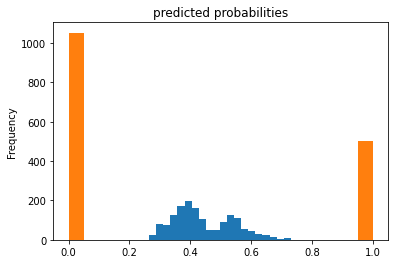

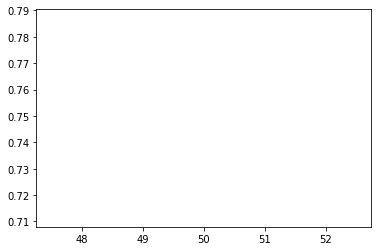

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.819302
accuracy_baseline         0.548255
auc                       0.899387
auc_precision_recall      0.874384
average_loss              0.490091
label/mean                0.451745
loss                      0.767441
precision                 0.777311
prediction/mean           0.469409
recall                    0.840909
global_step             100.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 53 on total: 311
0.8212036091249574
       FIPS  Result
0     17059       0
1      6103       1
2     42047       1
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       1
1553  48293       0
1554  37087       1

[1555 rows x 2 columns]
POST GRAPHS


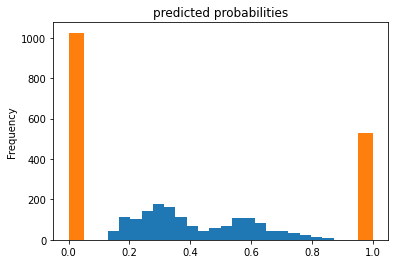

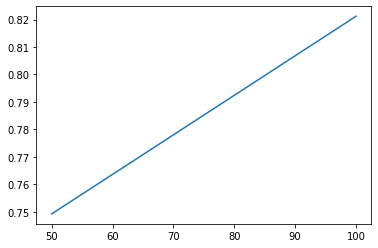

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.745631
accuracy_baseline         0.504854
auc                       0.870626
auc_precision_recall      0.871373
average_loss              0.476973
label/mean                0.495146
loss                      0.789843
precision                 0.787037
prediction/mean           0.444126
recall                    0.666667
global_step             150.000000
dtype: float64
WEIGHTED: 
D ERR: 17; R ERR: 46 on total: 311
0.7448717948717948
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       1

[1555 rows x 2 columns]
POST GRAPHS


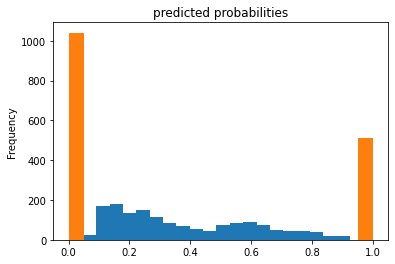

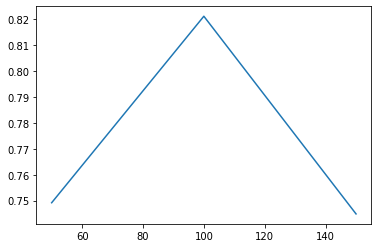

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.763860
accuracy_baseline         0.548255
auc                       0.852741
auc_precision_recall      0.837795
average_loss              0.479688
label/mean                0.451745
loss                      0.751152
precision                 0.744186
prediction/mean           0.429029
recall                    0.727273
global_step             200.000000
dtype: float64
WEIGHTED: 
D ERR: 12; R ERR: 55 on total: 311
0.7606401089547157
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       1

[1555 rows x 2 columns]
POST GRAPHS


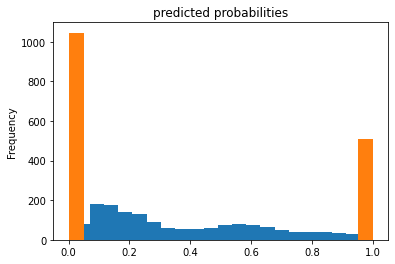

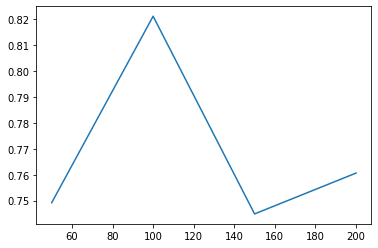

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


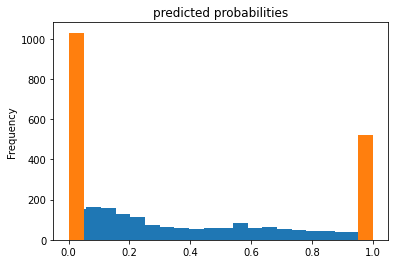

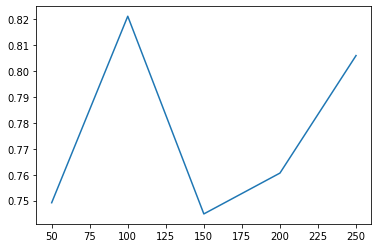

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

Length: 1555, dtype: float64
accuracy                  0.814737
accuracy_baseline         0.568421
auc                       0.916125
auc_precision_recall      0.877673
average_loss              0.377802
label/mean                0.431579
loss                      0.577028
precision                 0.788177
prediction/mean           0.451291
recall                    0.780488
global_step             300.000000
dtype: float64
WEIGHTED: 
D ERR: 9; R ERR: 43 on total: 311
0.8106142728093948
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


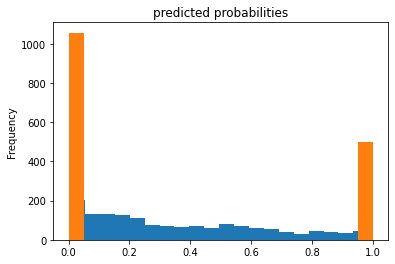

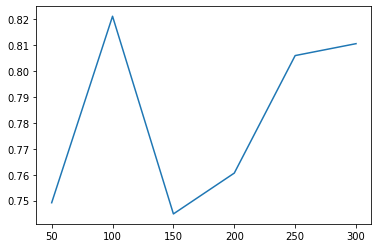

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.882957
accuracy_baseline         0.548255
auc                       0.945438
auc_precision_recall      0.936427
average_loss              0.333765
label/mean                0.451745
loss                      0.522648
precision                 0.859031
prediction/mean           0.459315
recall                    0.886364
global_step             350.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 32 on total: 311
0.8832567245488594
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


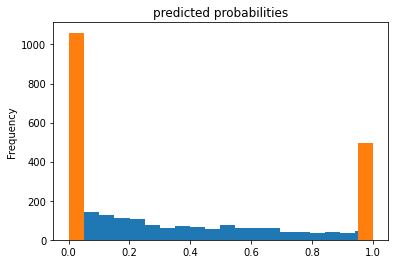

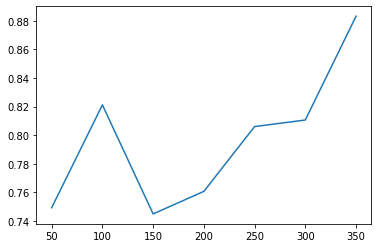

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


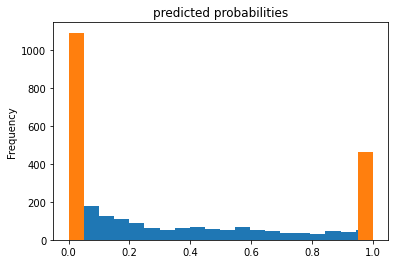

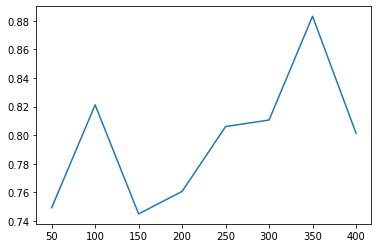

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


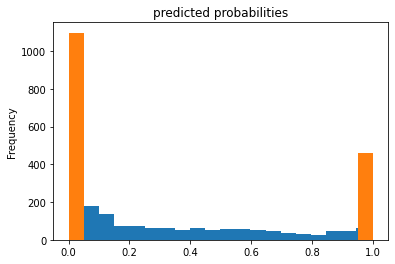

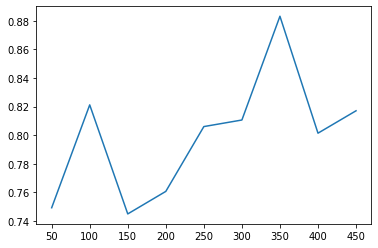

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


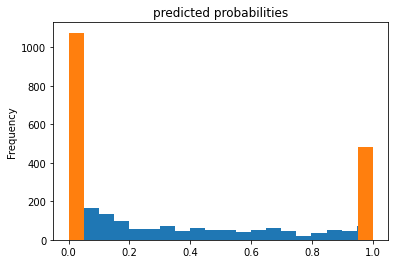

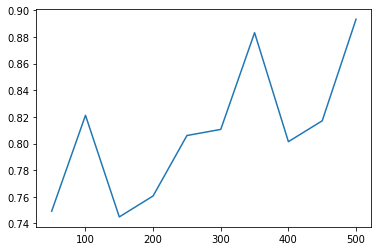

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


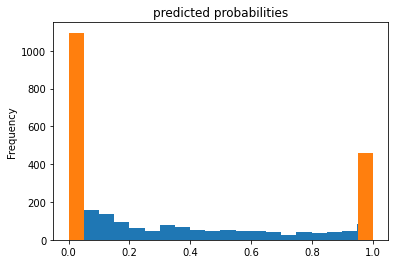

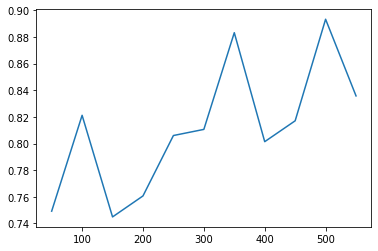

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.860370
accuracy_baseline         0.548255
auc                       0.950545
auc_precision_recall      0.941249
average_loss              0.298762
label/mean                0.451745
loss                      0.467837
precision                 0.848624
prediction/mean           0.445267
recall                    0.840909
global_step             600.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 33 on total: 311
0.8586567926455566
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


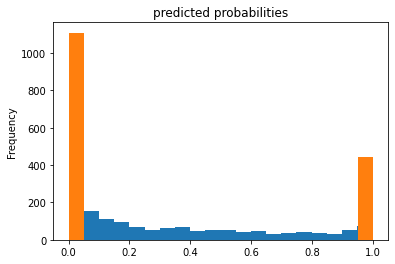

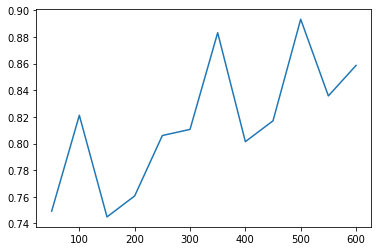

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

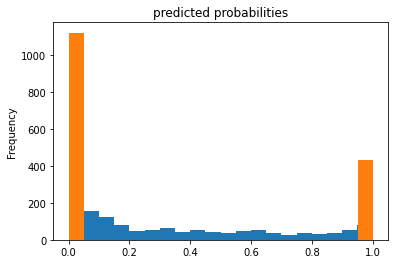

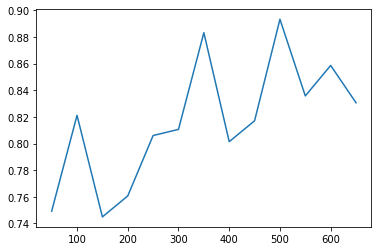

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.821355
accuracy_baseline         0.548255
auc                       0.915645
auc_precision_recall      0.902187
average_loss              0.366849
label/mean                0.451745
loss                      0.574455
precision                 0.821256
prediction/mean           0.420571
recall                    0.772727
global_step             700.000000
dtype: float64
WEIGHTED: 
D ERR: 10; R ERR: 37 on total: 311
0.8170752468505278
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


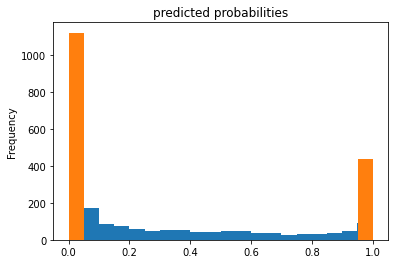

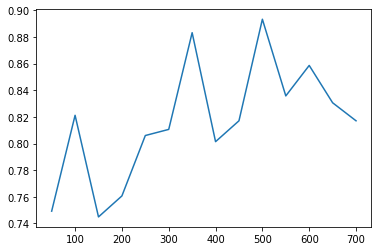

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.924644
accuracy_baseline         0.541752
auc                       0.969256
auc_precision_recall      0.953277
average_loss              0.242522
label/mean                0.458248
loss                      0.382889
precision                 0.858779
prediction/mean           0.487080
recall                    1.000000
global_step             750.000000
dtype: float64
WEIGHTED: 
D ERR: 0; R ERR: 37 on total: 311
0.9304511278195489
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


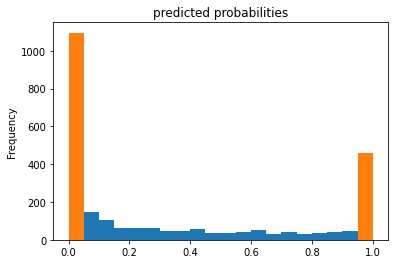

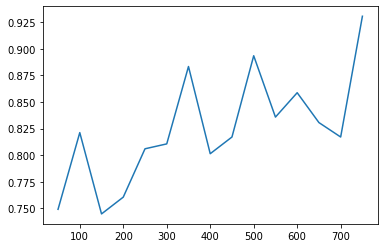

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                  0.846316
accuracy_baseline         0.568421
auc                       0.936043
auc_precision_recall      0.911869
average_loss              0.320869
label/mean                0.431579
loss                      0.490074
precision                 0.833333
prediction/mean           0.426798
recall                    0.804878
global_step             800.000000
dtype: float64
WEIGHTED: 
D ERR: 8; R ERR: 33 on total: 311
0.8413279132791328
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


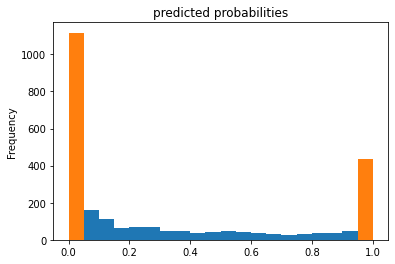

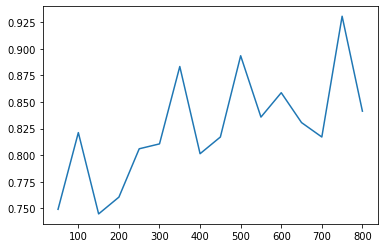

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

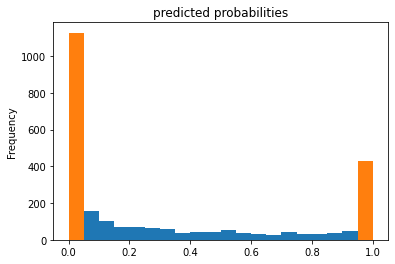

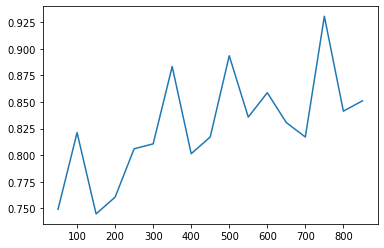

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


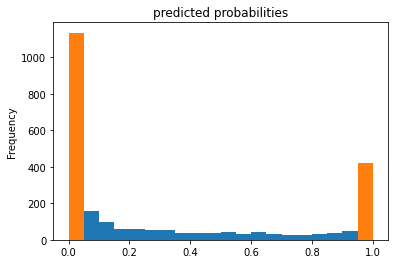

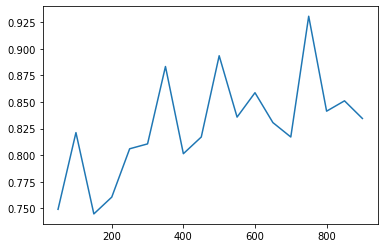

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

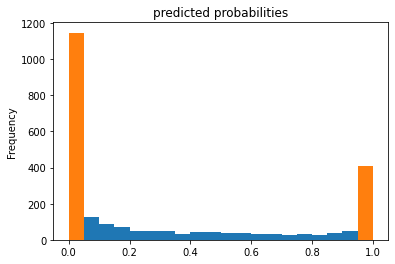

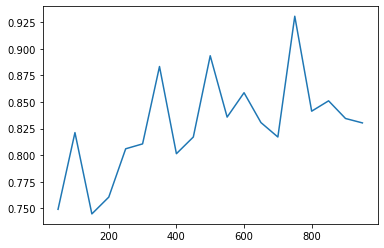

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

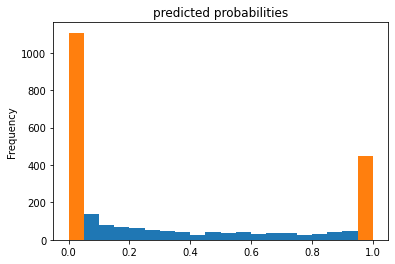

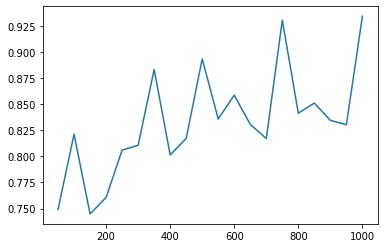

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


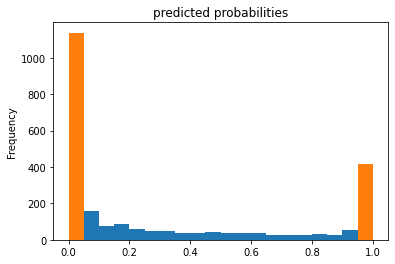

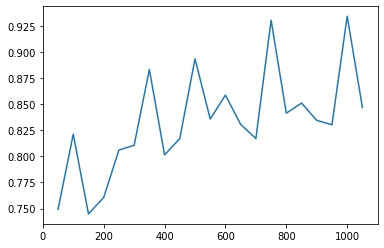

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


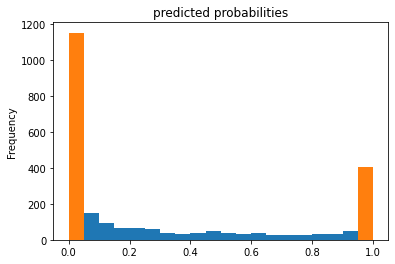

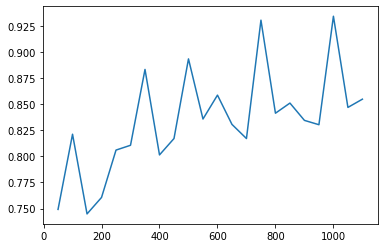

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.842718
accuracy_baseline          0.504854
auc                        0.948605
auc_precision_recall       0.942595
average_loss               0.286556
label/mean                 0.495146
loss                       0.474521
precision                  0.868644
prediction/mean            0.461458
recall                     0.803922
global_step             1150.000000
dtype: float64
WEIGHTED: 
D ERR: 10; R ERR: 31 on total: 311
0.8423453996983409
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


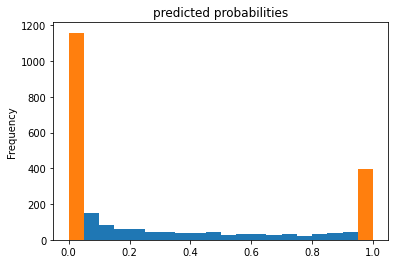

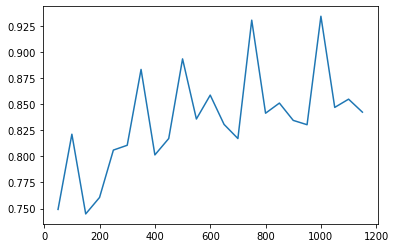

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.835729
accuracy_baseline          0.548255
auc                        0.933010
auc_precision_recall       0.917413
average_loss               0.326407
label/mean                 0.451745
loss                       0.511126
precision                  0.833333
prediction/mean            0.422112
recall                     0.795455
global_step             1200.000000
dtype: float64
WEIGHTED: 
D ERR: 9; R ERR: 35 on total: 311
0.832184201566224
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


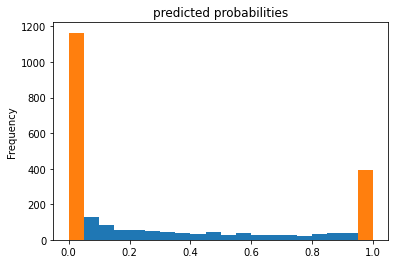

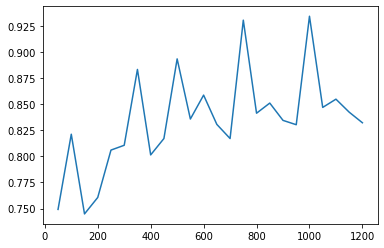

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.930754
accuracy_baseline          0.541752
auc                        0.980576
auc_precision_recall       0.972490
average_loss               0.195598
label/mean                 0.458248
loss                       0.308807
precision                  0.868726
prediction/mean            0.488217
recall                     1.000000
global_step             1250.000000
dtype: float64
WEIGHTED: 
D ERR: 0; R ERR: 34 on total: 311
0.9360902255639099
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


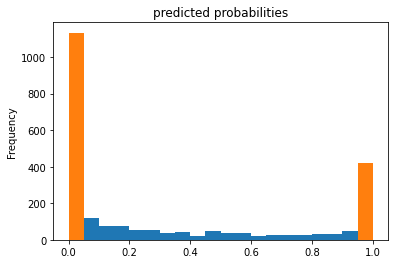

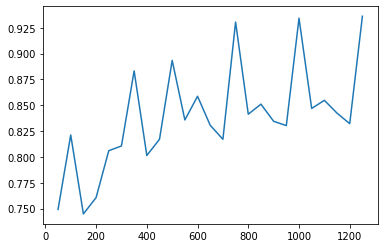

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.875789
accuracy_baseline          0.568421
auc                        0.942005
auc_precision_recall       0.918180
average_loss               0.313107
label/mean                 0.431579
loss                       0.478218
precision                  0.857843
prediction/mean            0.420910
recall                     0.853659
global_step             1300.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 29 on total: 311
0.8731255645889792
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


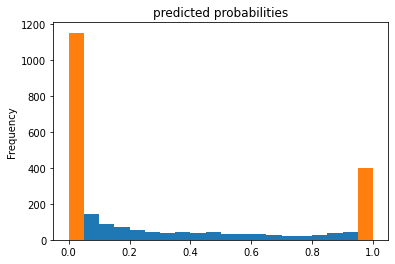

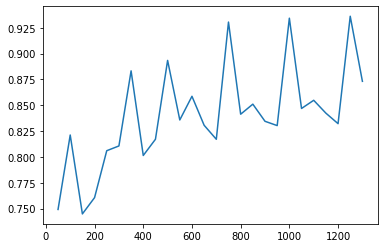

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.848049
accuracy_baseline          0.548255
auc                        0.957610
auc_precision_recall       0.947527
average_loss               0.266930
label/mean                 0.451745
loss                       0.417990
precision                  0.857843
prediction/mean            0.426115
recall                     0.795455
global_step             1350.000000
dtype: float64
WEIGHTED: 
D ERR: 9; R ERR: 29 on total: 311
0.8434201566224039
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


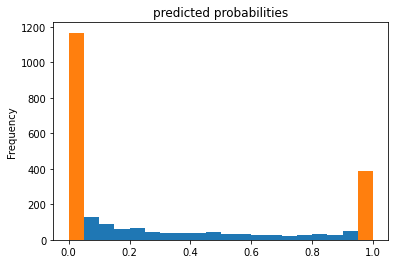

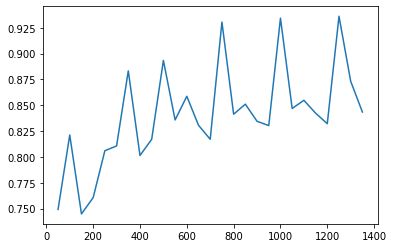

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.854369
accuracy_baseline          0.504854
auc                        0.952413
auc_precision_recall       0.946828
average_loss               0.273964
label/mean                 0.495146
loss                       0.453670
precision                  0.875000
prediction/mean            0.465284
recall                     0.823529
global_step             1400.000000
dtype: float64
WEIGHTED: 
D ERR: 9; R ERR: 30 on total: 311
0.8540723981900453
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


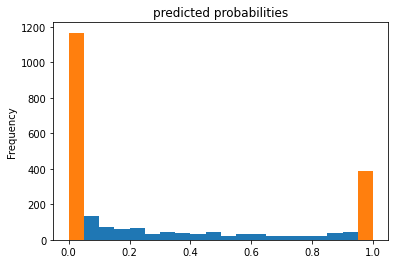

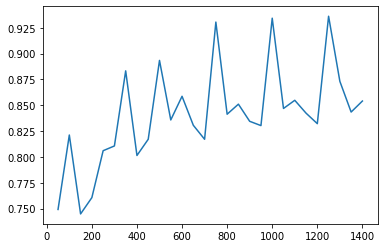

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.850103
accuracy_baseline          0.548255
auc                        0.939522
auc_precision_recall       0.924529
average_loss               0.310065
label/mean                 0.451745
loss                       0.485536
precision                  0.845070
prediction/mean            0.423133
recall                     0.818182
global_step             1450.000000
dtype: float64
WEIGHTED: 
D ERR: 8; R ERR: 33 on total: 311
0.8472931562819204
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


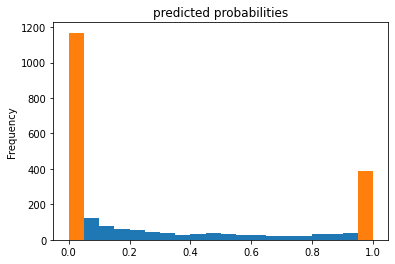

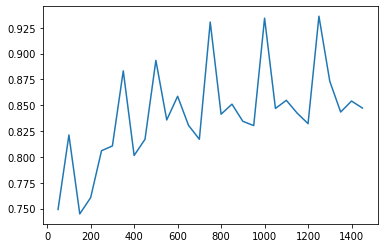

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.942973
accuracy_baseline          0.541752
auc                        0.983124
auc_precision_recall       0.972304
average_loss               0.182710
label/mean                 0.458248
loss                       0.288458
precision                  0.889328
prediction/mean            0.489713
recall                     1.000000
global_step             1500.000000
dtype: float64
WEIGHTED: 
D ERR: 0; R ERR: 28 on total: 311
0.9473684210526316
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


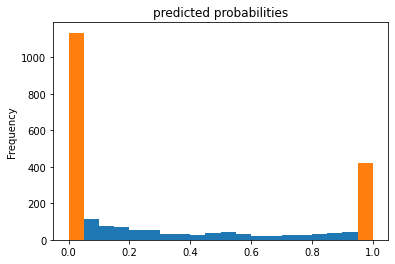

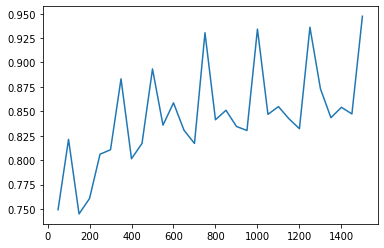

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.880000
accuracy_baseline          0.568421
auc                        0.943857
auc_precision_recall       0.917692
average_loss               0.308512
label/mean                 0.431579
loss                       0.471199
precision                  0.866337
prediction/mean            0.417193
recall                     0.853659
global_step             1550.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 27 on total: 311
0.876829268292683
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


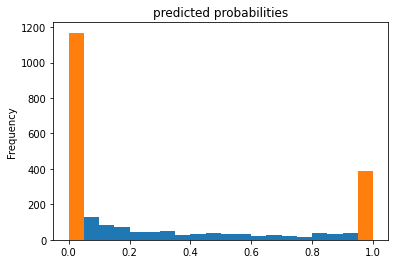

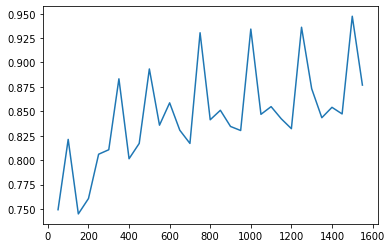

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.862423
accuracy_baseline          0.548255
auc                        0.960546
auc_precision_recall       0.950993
average_loss               0.256755
label/mean                 0.451745
loss                       0.402057
precision                  0.869565
prediction/mean            0.424192
recall                     0.818182
global_step             1600.000000
dtype: float64
WEIGHTED: 
D ERR: 8; R ERR: 27 on total: 311
0.8585291113381001
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


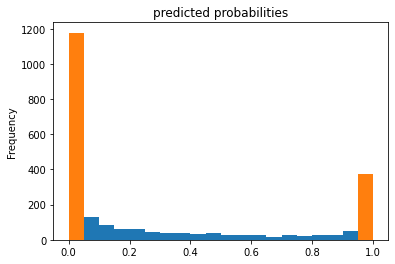

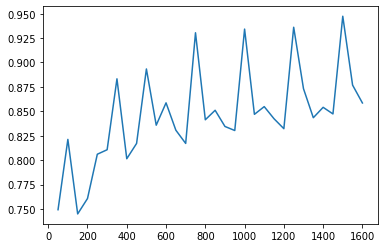

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.854369
accuracy_baseline          0.504854
auc                        0.955882
auc_precision_recall       0.950785
average_loss               0.262778
label/mean                 0.495146
loss                       0.435146
precision                  0.875000
prediction/mean            0.465636
recall                     0.823529
global_step             1650.000000
dtype: float64
WEIGHTED: 
D ERR: 9; R ERR: 30 on total: 311
0.8540723981900453
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


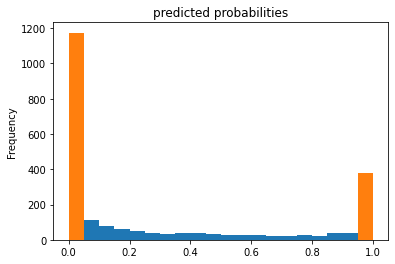

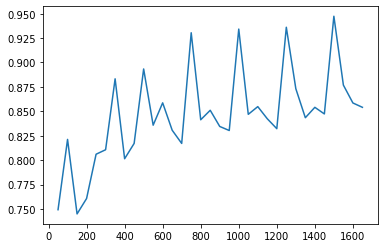

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.856263
accuracy_baseline          0.548255
auc                        0.944714
auc_precision_recall       0.930216
average_loss               0.297891
label/mean                 0.451745
loss                       0.466473
precision                  0.857143
prediction/mean            0.423114
recall                     0.818182
global_step             1700.000000
dtype: float64
WEIGHTED: 
D ERR: 8; R ERR: 30 on total: 311
0.8529111338100102
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


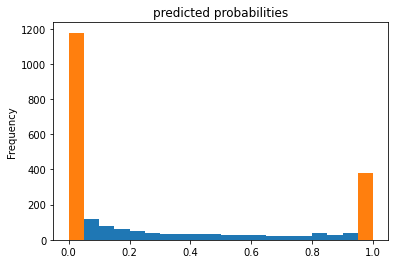

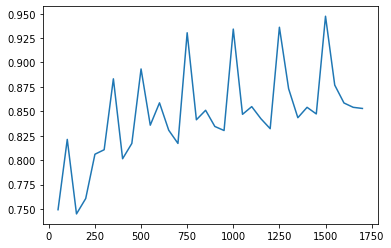

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


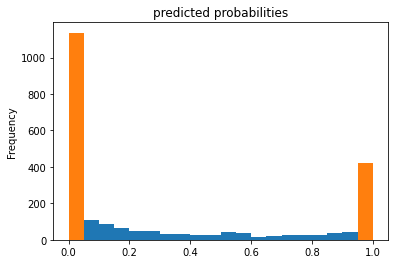

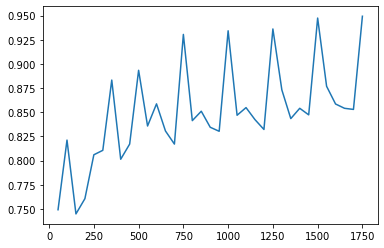

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.880000
accuracy_baseline          0.568421
auc                        0.946612
auc_precision_recall       0.921881
average_loss               0.302885
label/mean                 0.431579
loss                       0.462605
precision                  0.866337
prediction/mean            0.418273
recall                     0.853659
global_step             1800.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 27 on total: 311
0.876829268292683
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


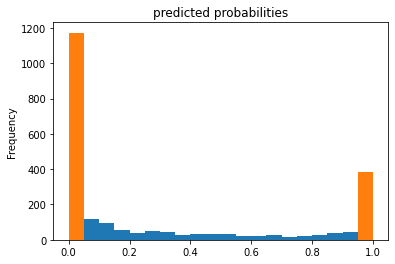

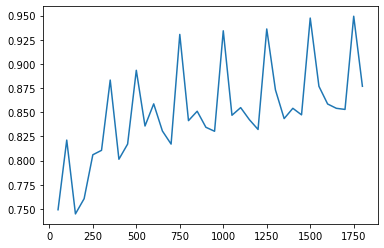

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.872690
accuracy_baseline          0.548255
auc                        0.962547
auc_precision_recall       0.952854
average_loss               0.249234
label/mean                 0.451745
loss                       0.390279
precision                  0.872642
prediction/mean            0.422264
recall                     0.840909
global_step             1850.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 27 on total: 311
0.8698927477017365
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


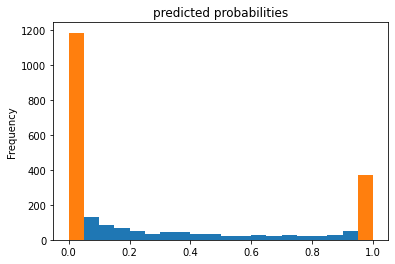

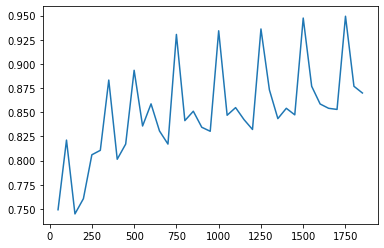

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

Length: 1555, dtype: float64
accuracy                   0.877670
accuracy_baseline          0.504854
auc                        0.958861
auc_precision_recall       0.954163
average_loss               0.252983
label/mean                 0.495146
loss                       0.418926
precision                  0.887097
prediction/mean            0.467451
recall                     0.862745
global_step             1900.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 28 on total: 311
0.8775263951734541
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


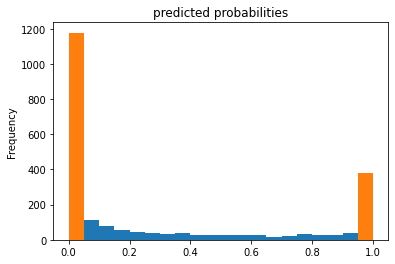

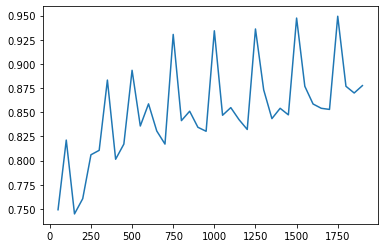

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

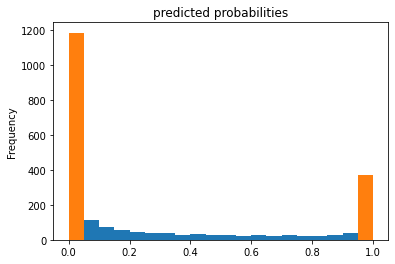

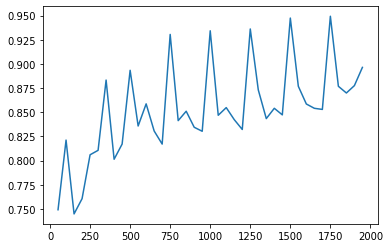

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.947047
accuracy_baseline          0.541752
auc                        0.985464
auc_precision_recall       0.976205
average_loss               0.166728
label/mean                 0.458248
loss                       0.263226
precision                  0.896414
prediction/mean            0.487110
recall                     1.000000
global_step             2000.000000
dtype: float64
WEIGHTED: 
D ERR: 0; R ERR: 26 on total: 311
0.9511278195488722
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


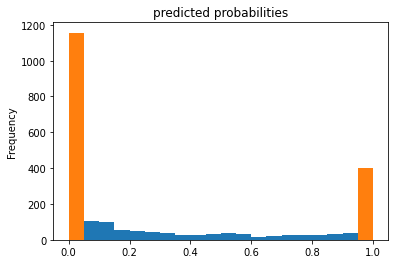

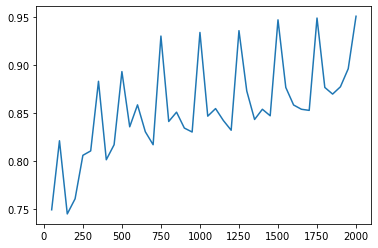

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.880000
accuracy_baseline          0.568421
auc                        0.949910
auc_precision_recall       0.924421
average_loss               0.293681
label/mean                 0.431579
loss                       0.448549
precision                  0.866337
prediction/mean            0.419055
recall                     0.853659
global_step             2050.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 27 on total: 311
0.876829268292683
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


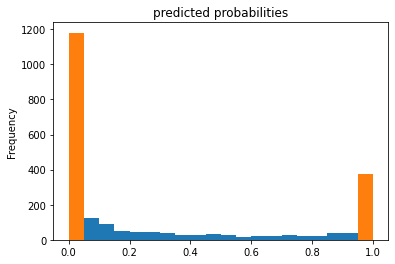

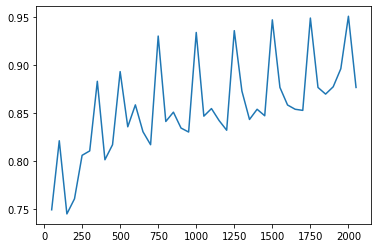

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.876797
accuracy_baseline          0.548255
auc                        0.966845
auc_precision_recall       0.957601
average_loss               0.238690
label/mean                 0.451745
loss                       0.373769
precision                  0.880952
prediction/mean            0.421607
recall                     0.840909
global_step             2100.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 25 on total: 311
0.8736380660537963
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


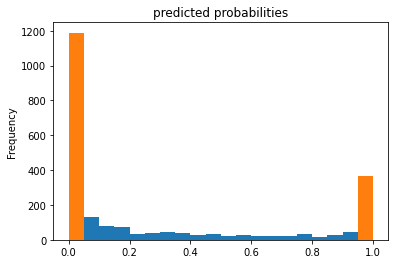

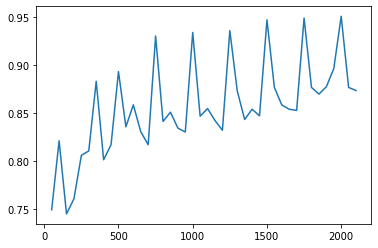

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

0       0.004812
1       0.767803
2       0.004503
3       0.010452
4       0.011142
          ...   
1550    0.558438
1551    0.984581
1552    0.011564
1553    0.230049
1554    0.320489
Length: 1555, dtype: float64
accuracy                   0.887379
accuracy_baseline          0.504854
auc                        0.961463
auc_precision_recall       0.956654
average_loss               0.244586
label/mean                 0.495146
loss                       0.405022
precision                  0.889328
prediction/mean            0.466957
recall                     0.882353
global_step             2150.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 28 on total: 311
0.8873303167420814
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


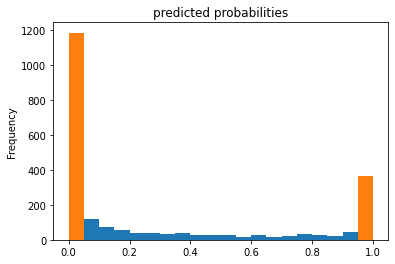

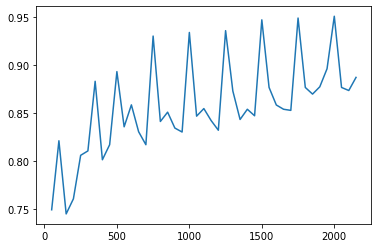

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

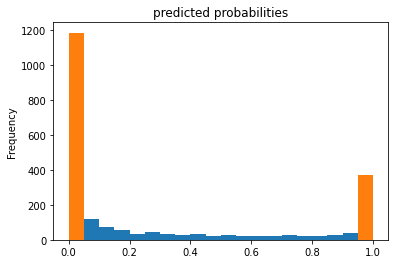

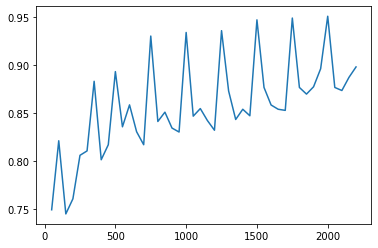

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


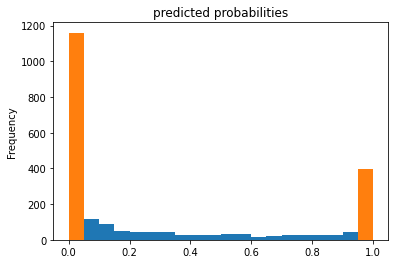

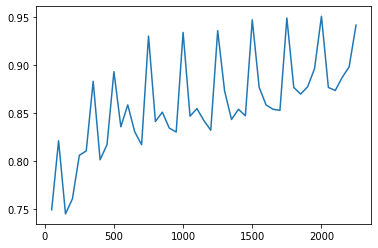

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.880000
accuracy_baseline          0.568421
auc                        0.952213
auc_precision_recall       0.923027
average_loss               0.287973
label/mean                 0.431579
loss                       0.439831
precision                  0.866337
prediction/mean            0.417225
recall                     0.853659
global_step             2300.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 27 on total: 311
0.876829268292683
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


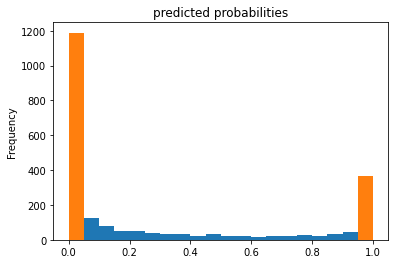

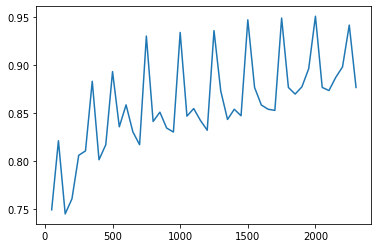

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.878850
accuracy_baseline          0.548255
auc                        0.968888
auc_precision_recall       0.959803
average_loss               0.229862
label/mean                 0.451745
loss                       0.359945
precision                  0.885167
prediction/mean            0.418324
recall                     0.840909
global_step             2350.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 24 on total: 311
0.8755107252298263
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


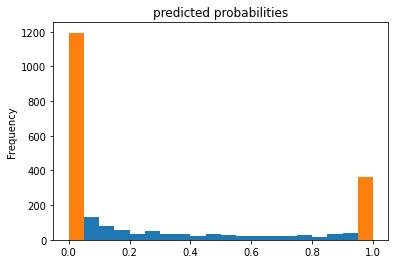

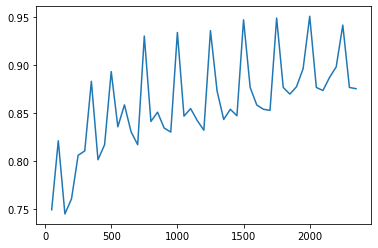

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


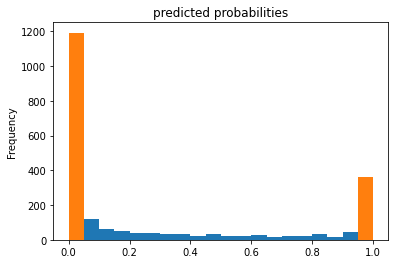

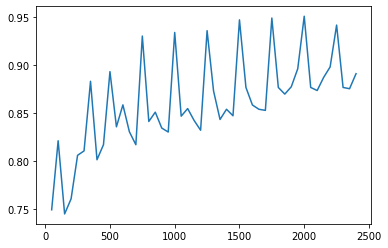

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.901437
accuracy_baseline          0.548255
auc                        0.958078
auc_precision_recall       0.946883
average_loss               0.256153
label/mean                 0.451745
loss                       0.401114
precision                  0.894495
prediction/mean            0.426821
recall                     0.886364
global_step             2450.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 23 on total: 311
0.9001106571331292
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


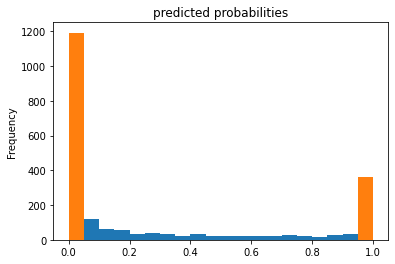

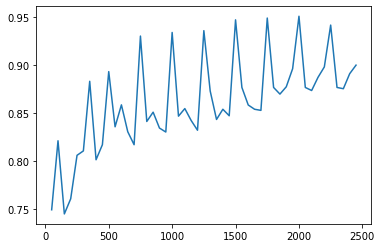

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

0       0.001429
1       0.767118
2       0.010622
3       0.012718
4       0.023354
          ...   
1550    0.518787
1551    0.988240
1552    0.023060
1553    0.278844
1554    0.235653
Length: 1555, dtype: float64
accuracy                   0.940937
accuracy_baseline          0.541752
auc                        0.986967
auc_precision_recall       0.977974
average_loss               0.156803
label/mean                 0.458248
loss                       0.247558
precision                  0.901639
prediction/mean            0.487153
recall                     0.977778
global_step             2500.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 24 on total: 311
0.9437761069340017
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


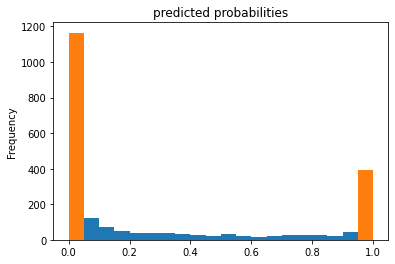

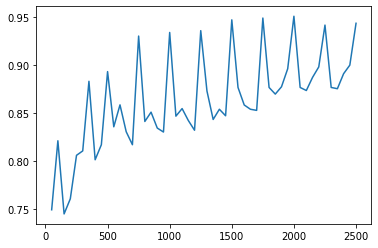

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

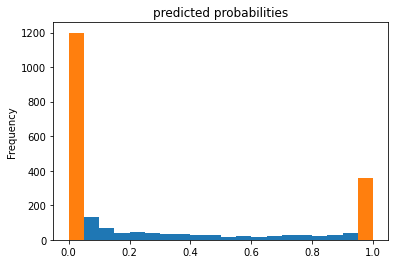

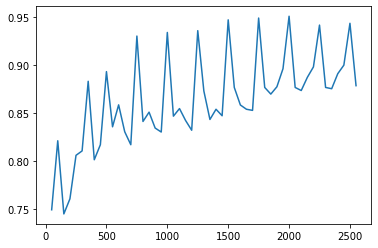

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.882957
accuracy_baseline          0.548255
auc                        0.971697
auc_precision_recall       0.963245
average_loss               0.220567
label/mean                 0.451745
loss                       0.345389
precision                  0.893720
prediction/mean            0.418801
recall                     0.840909
global_step             2600.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 22 on total: 311
0.8792560435818862
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


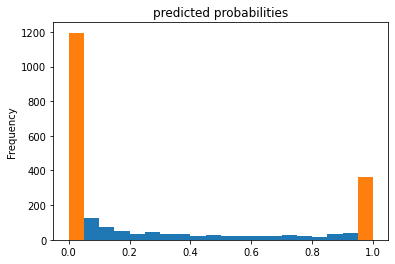

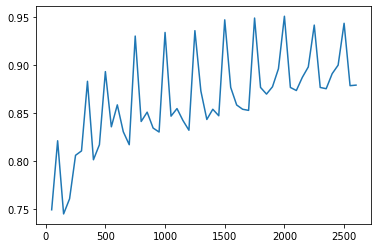

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

0       0.002395
1       0.737394
2       0.002799
3       0.007826
4       0.008671
          ...   
1550    0.577937
1551    0.986931
1552    0.006613
1553    0.253366
1554    0.273898
Length: 1555, dtype: float64
accuracy                   0.895146
accuracy_baseline          0.504854
auc                        0.966252
auc_precision_recall       0.961904
average_loss               0.227110
label/mean                 0.495146
loss                       0.376082
precision                  0.903614
prediction/mean            0.467510
recall                     0.882353
global_step             2650.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 24 on total: 311
0.895022624434389
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


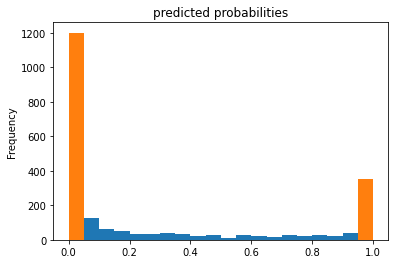

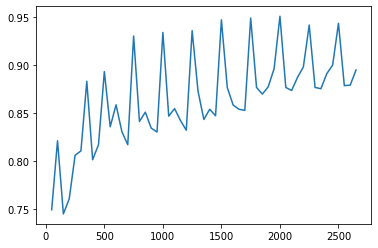

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.899384
accuracy_baseline          0.548255
auc                        0.961823
auc_precision_recall       0.951163
average_loss               0.244723
label/mean                 0.451745
loss                       0.383216
precision                  0.890411
prediction/mean            0.426306
recall                     0.886364
global_step             2700.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 24 on total: 311
0.8982379979570992
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


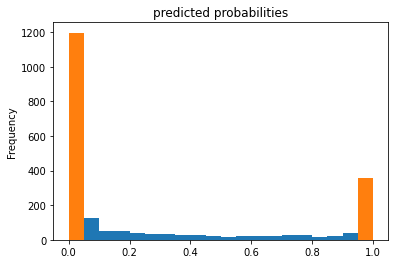

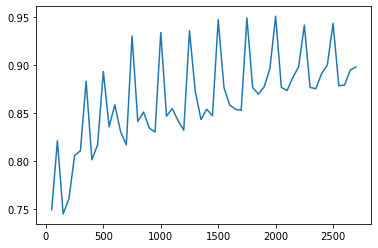

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.940937
accuracy_baseline          0.541752
auc                        0.986926
auc_precision_recall       0.977905
average_loss               0.150974
label/mean                 0.458248
loss                       0.238355
precision                  0.901639
prediction/mean            0.484351
recall                     0.977778
global_step             2750.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 24 on total: 311
0.9437761069340017
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


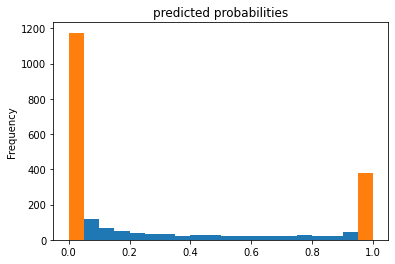

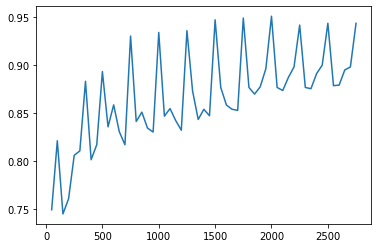

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.886316
accuracy_baseline          0.568421
auc                        0.955285
auc_precision_recall       0.927405
average_loss               0.277126
label/mean                 0.431579
loss                       0.423263
precision                  0.879397
prediction/mean            0.416243
recall                     0.853659
global_step             2800.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 24 on total: 311
0.8823848238482386
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


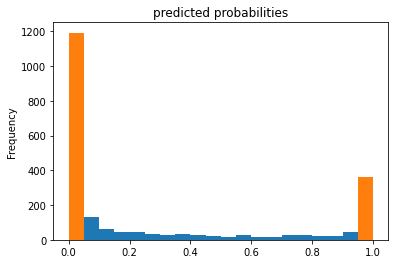

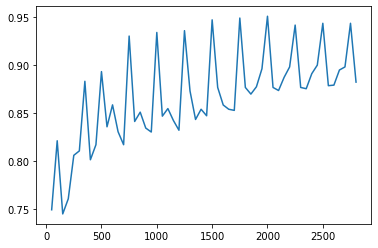

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

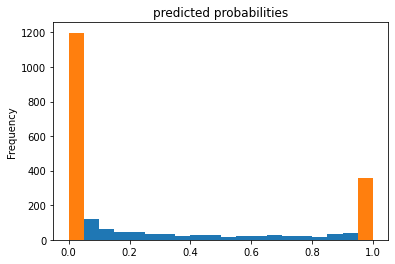

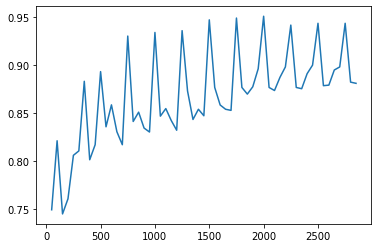

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.895146
accuracy_baseline          0.504854
auc                        0.969080
auc_precision_recall       0.965438
average_loss               0.217579
label/mean                 0.495146
loss                       0.360299
precision                  0.903614
prediction/mean            0.469738
recall                     0.882353
global_step             2900.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 24 on total: 311
0.895022624434389
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


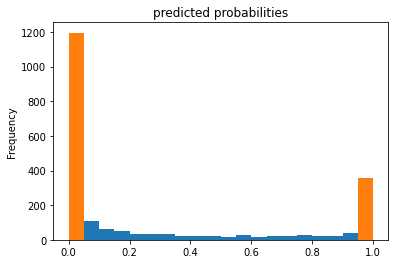

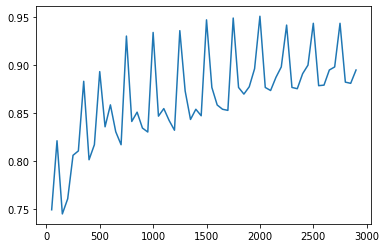

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.901437
accuracy_baseline          0.548255
auc                        0.965313
auc_precision_recall       0.955346
average_loss               0.235635
label/mean                 0.451745
loss                       0.368985
precision                  0.894495
prediction/mean            0.425808
recall                     0.886364
global_step             2950.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 23 on total: 311
0.9001106571331292
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


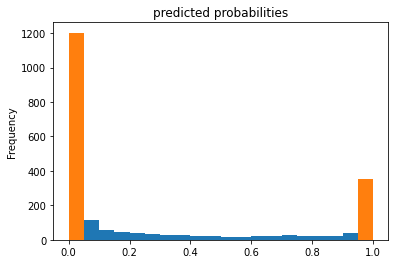

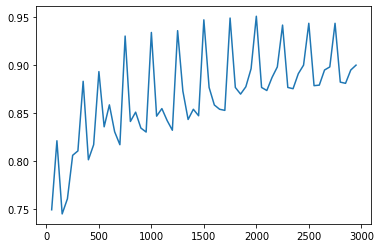

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.942973
accuracy_baseline          0.541752
auc                        0.986967
auc_precision_recall       0.977923
average_loss               0.148971
label/mean                 0.458248
loss                       0.235192
precision                  0.905350
prediction/mean            0.482132
recall                     0.977778
global_step             3000.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 23 on total: 311
0.9456558061821221
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


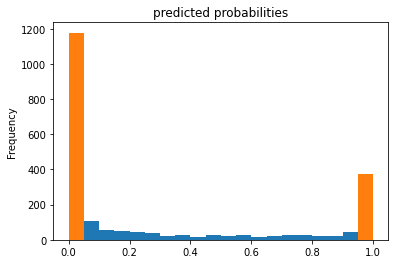

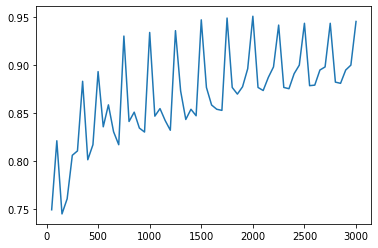

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.886316
accuracy_baseline          0.568421
auc                        0.957272
auc_precision_recall       0.930818
average_loss               0.271415
label/mean                 0.431579
loss                       0.414540
precision                  0.879397
prediction/mean            0.415037
recall                     0.853659
global_step             3050.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 24 on total: 311
0.8823848238482386
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


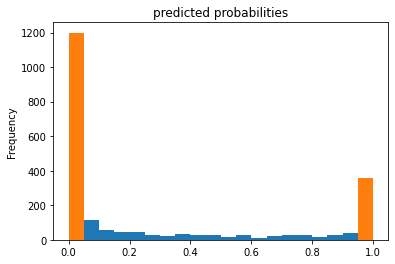

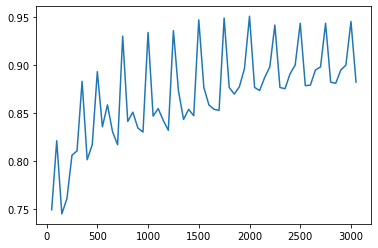

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.887064
accuracy_baseline          0.548255
auc                        0.975145
auc_precision_recall       0.967163
average_loss               0.204940
label/mean                 0.451745
loss                       0.320919
precision                  0.902439
prediction/mean            0.418070
recall                     0.840909
global_step             3100.000000
dtype: float64
WEIGHTED: 
D ERR: 7; R ERR: 20 on total: 311
0.8830013619339461
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


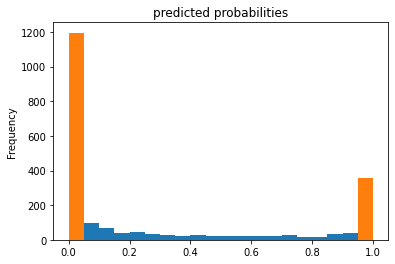

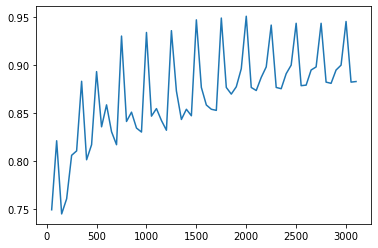

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.895146
accuracy_baseline          0.504854
auc                        0.970664
auc_precision_recall       0.967600
average_loss               0.211700
label/mean                 0.495146
loss                       0.350564
precision                  0.903614
prediction/mean            0.469631
recall                     0.882353
global_step             3150.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 24 on total: 311
0.895022624434389
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


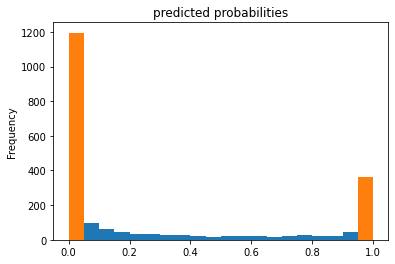

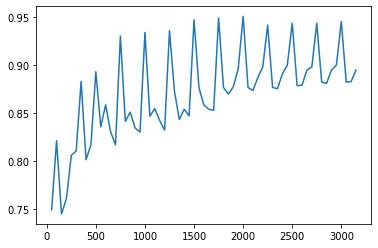

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.899384
accuracy_baseline          0.548255
auc                        0.967782
auc_precision_recall       0.958403
average_loss               0.226890
label/mean                 0.451745
loss                       0.355292
precision                  0.890411
prediction/mean            0.426335
recall                     0.886364
global_step             3200.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 24 on total: 311
0.8982379979570992
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


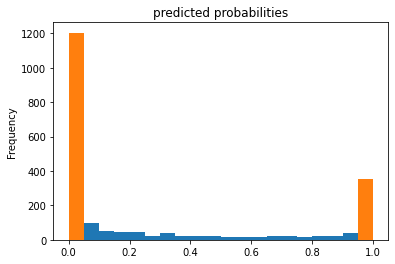

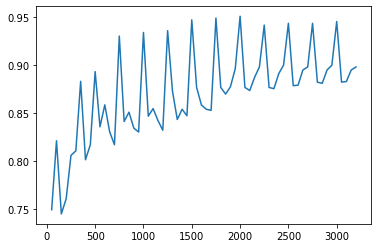

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.945010
accuracy_baseline          0.541752
auc                        0.987427
auc_precision_recall       0.978774
average_loss               0.146343
label/mean                 0.458248
loss                       0.231043
precision                  0.909091
prediction/mean            0.481343
recall                     0.977778
global_step             3250.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 22 on total: 311
0.9475355054302422
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


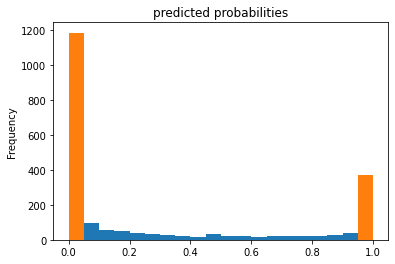

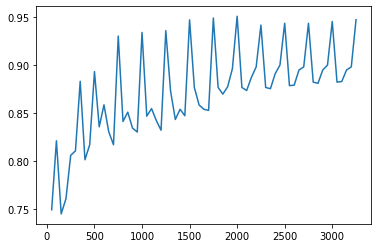

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.890526
accuracy_baseline          0.568421
auc                        0.958220
auc_precision_recall       0.931965
average_loss               0.267449
label/mean                 0.431579
loss                       0.408484
precision                  0.888325
prediction/mean            0.413370
recall                     0.853659
global_step             3300.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 22 on total: 311
0.8860885275519421
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


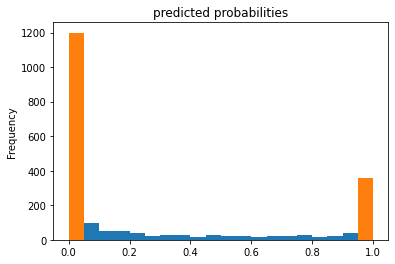

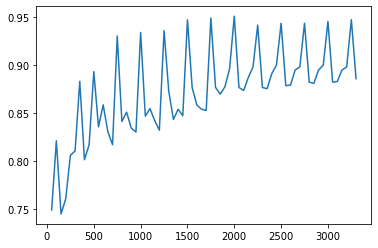

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


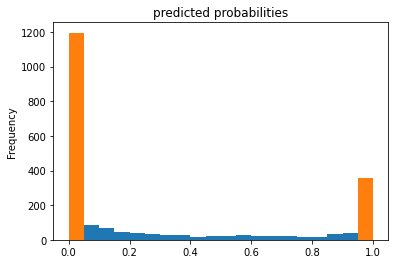

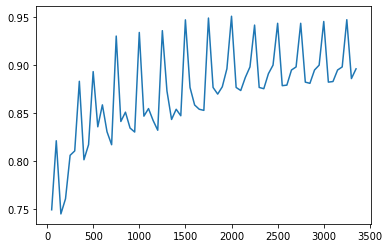

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.906796
accuracy_baseline          0.504854
auc                        0.972247
auc_precision_recall       0.969403
average_loss               0.206983
label/mean                 0.495146
loss                       0.342754
precision                  0.909091
prediction/mean            0.469509
recall                     0.901961
global_step             3400.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 23 on total: 311
0.9067496229260934
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


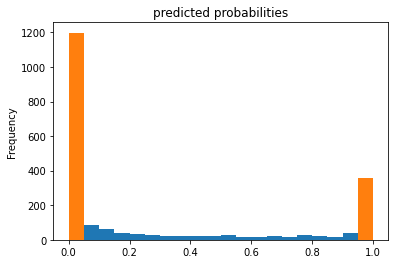

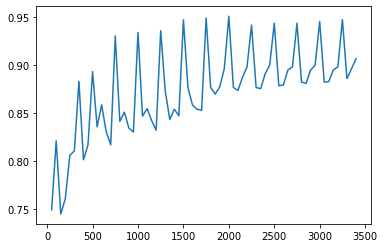

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

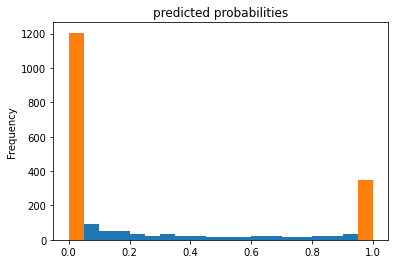

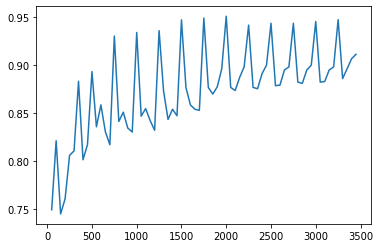

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

Length: 1555, dtype: float64
accuracy                   0.942973
accuracy_baseline          0.541752
auc                        0.987677
auc_precision_recall       0.979090
average_loss               0.144484
label/mean                 0.458248
loss                       0.228108
precision                  0.905350
prediction/mean            0.481294
recall                     0.977778
global_step             3500.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 23 on total: 311
0.9456558061821221
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


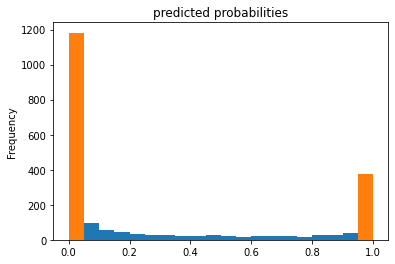

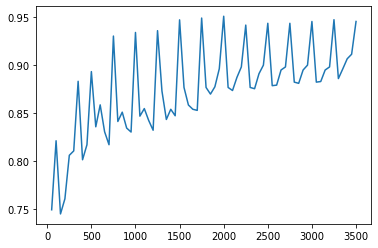

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.892632
accuracy_baseline          0.568421
auc                        0.959259
auc_precision_recall       0.933114
average_loss               0.264038
label/mean                 0.431579
loss                       0.403274
precision                  0.892857
prediction/mean            0.412892
recall                     0.853659
global_step             3550.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 21 on total: 311
0.8879403794037941
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


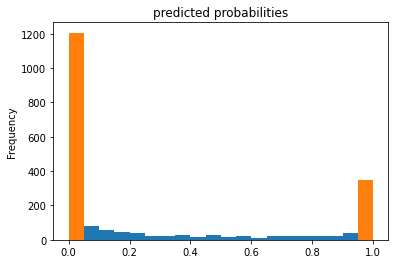

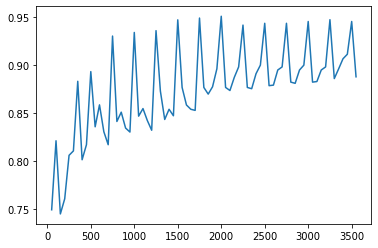

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

Length: 1555, dtype: float64
accuracy                   0.911704
accuracy_baseline          0.548255
auc                        0.978124
auc_precision_recall       0.970920
average_loss               0.191471
label/mean                 0.451745
loss                       0.299827
precision                  0.915493
prediction/mean            0.419670
recall                     0.886364
global_step             3600.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 18 on total: 311
0.9094739530132789
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


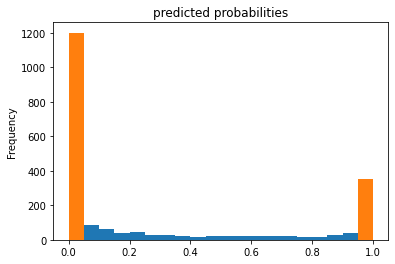

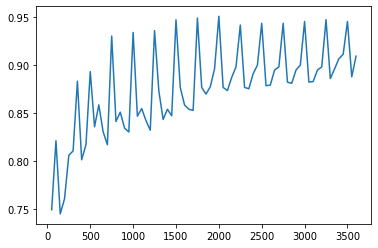

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.897087
accuracy_baseline          0.504854
auc                        0.973039
auc_precision_recall       0.970376
average_loss               0.203007
label/mean                 0.495146
loss                       0.336170
precision                  0.907258
prediction/mean            0.468150
recall                     0.882353
global_step             3650.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 23 on total: 311
0.8969457013574661
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


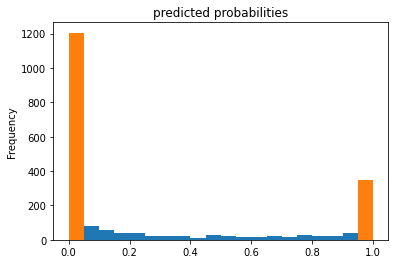

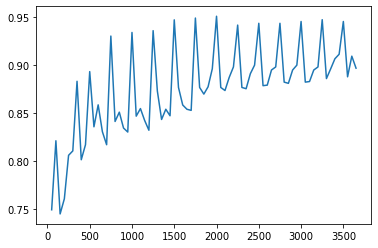

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


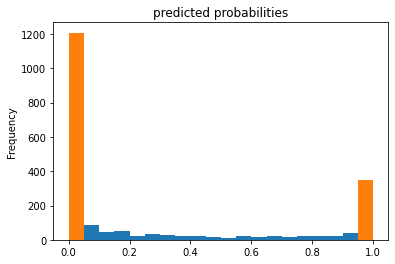

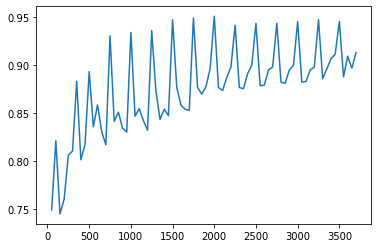

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

0       0.000267
1       0.720401
2       0.004756
3       0.003571
4       0.014946
          ...   
1550    0.597014
1551    0.987998
1552    0.008635
1553    0.366735
1554    0.162664
Length: 1555, dtype: float64
accuracy                   0.942973
accuracy_baseline          0.541752
auc                        0.988304
auc_precision_recall       0.979847
average_loss               0.141837
label/mean                 0.458248
loss                       0.223929
precision                  0.905350
prediction/mean            0.479111
recall                     0.977778
global_step             3750.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 23 on total: 311
0.9456558061821221
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


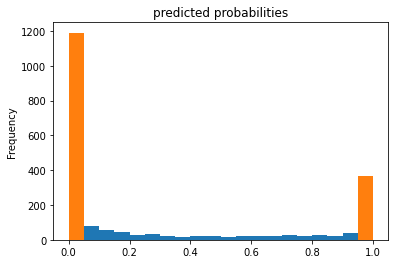

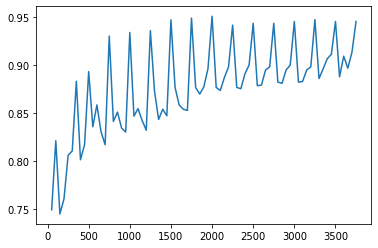

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

0       0.000703
1       0.646553
2       0.008358
3       0.003014
4       0.011395
          ...   
1550    0.326274
1551    0.992897
1552    0.014798
1553    0.342852
1554    0.132614
Length: 1555, dtype: float64
accuracy                   0.888421
accuracy_baseline          0.568421
auc                        0.959711
auc_precision_recall       0.932671
average_loss               0.260824
label/mean                 0.431579
loss                       0.398364
precision                  0.883838
prediction/mean            0.414643
recall                     0.853659
global_step             3800.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 23 on total: 311
0.8842366757000903
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


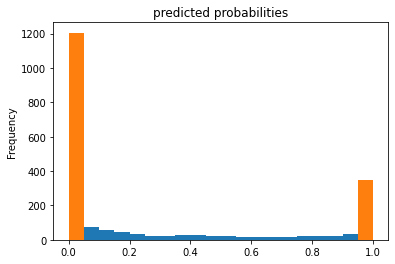

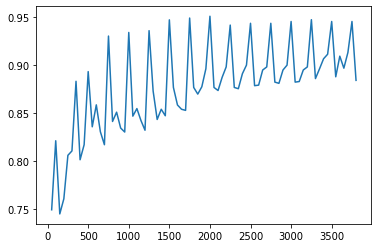

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

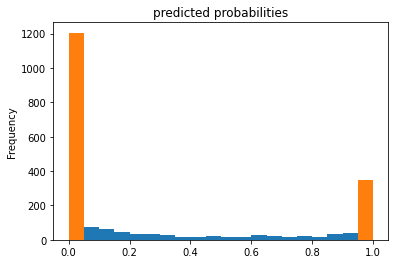

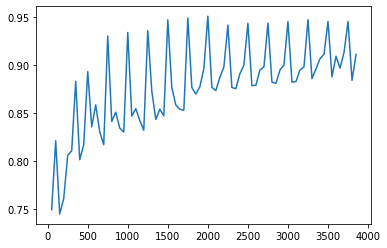

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

0       0.000540
1       0.698552
2       0.000969
3       0.002559
4       0.005450
          ...   
1550    0.657260
1551    0.987677
1552    0.001936
1553    0.294858
1554    0.210906
Length: 1555, dtype: float64
accuracy                   0.908738
accuracy_baseline          0.504854
auc                        0.974397
auc_precision_recall       0.972048
average_loss               0.198215
label/mean                 0.495146
loss                       0.328234
precision                  0.912698
prediction/mean            0.468174
recall                     0.901961
global_step             3900.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 22 on total: 311
0.9086726998491705
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


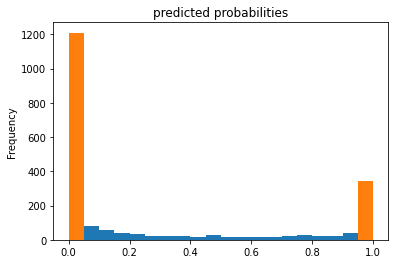

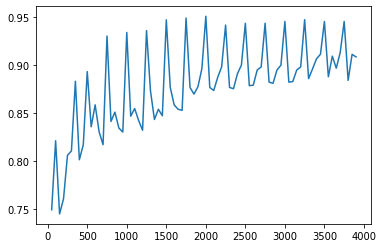

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.926078
accuracy_baseline          0.548255
auc                        0.971825
auc_precision_recall       0.963309
average_loss               0.207515
label/mean                 0.451745
loss                       0.324952
precision                  0.907080
prediction/mean            0.425629
recall                     0.931818
global_step             3950.000000
dtype: float64
WEIGHTED: 
D ERR: 3; R ERR: 21 on total: 311
0.9265832482124616
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


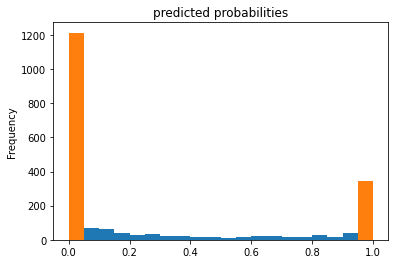

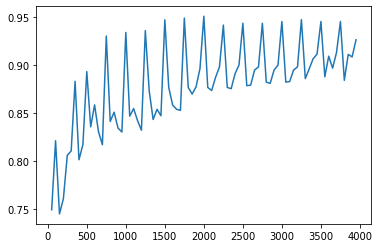

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.945010
accuracy_baseline          0.541752
auc                        0.988638
auc_precision_recall       0.980257
average_loss               0.140742
label/mean                 0.458248
loss                       0.222200
precision                  0.909091
prediction/mean            0.479583
recall                     0.977778
global_step             4000.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 22 on total: 311
0.9475355054302422
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


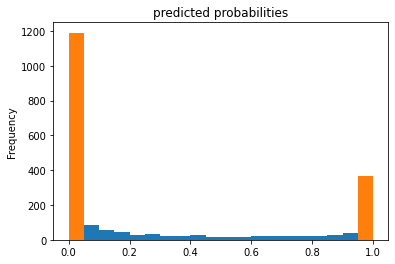

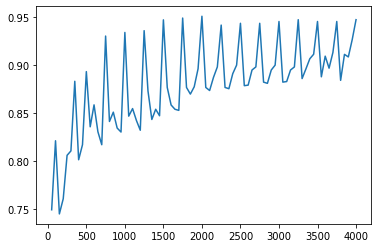

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.888421
accuracy_baseline          0.568421
auc                        0.962195
auc_precision_recall       0.935848
average_loss               0.257144
label/mean                 0.431579
loss                       0.392744
precision                  0.883838
prediction/mean            0.413270
recall                     0.853659
global_step             4050.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 23 on total: 311
0.8842366757000903
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


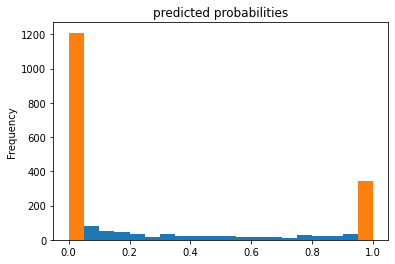

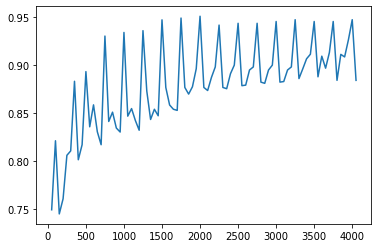

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.924025
accuracy_baseline          0.548255
auc                        0.981061
auc_precision_recall       0.974387
average_loss               0.179097
label/mean                 0.451745
loss                       0.280451
precision                  0.921659
prediction/mean            0.419524
recall                     0.909091
global_step             4100.000000
dtype: float64
WEIGHTED: 
D ERR: 4; R ERR: 17 on total: 311
0.9227102485529451
       FIPS  Result
0     17059       0
1      6103       0
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


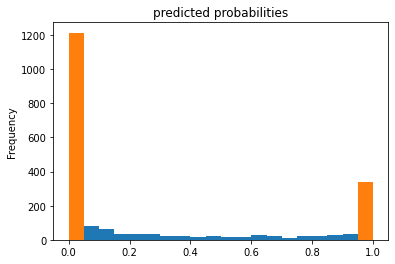

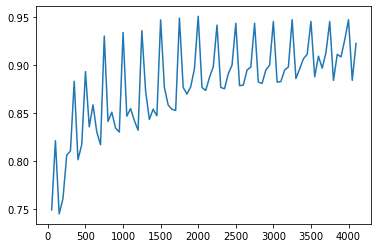

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.918447
accuracy_baseline          0.504854
auc                        0.975189
auc_precision_recall       0.972784
average_loss               0.195003
label/mean                 0.495146
loss                       0.322916
precision                  0.914397
prediction/mean            0.467861
recall                     0.921569
global_step             4150.000000
dtype: float64
WEIGHTED: 
D ERR: 4; R ERR: 22 on total: 311
0.9184766214177978
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


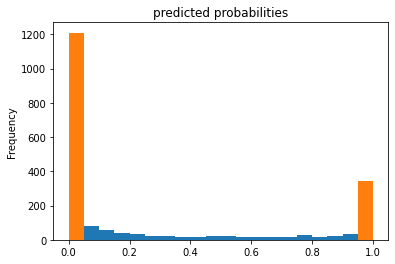

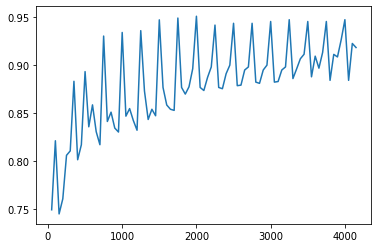

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.936345
accuracy_baseline          0.548255
auc                        0.972889
auc_precision_recall       0.964254
average_loss               0.200873
label/mean                 0.451745
loss                       0.314551
precision                  0.909091
prediction/mean            0.426676
recall                     0.954545
global_step             4200.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 21 on total: 311
0.937946884576098
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


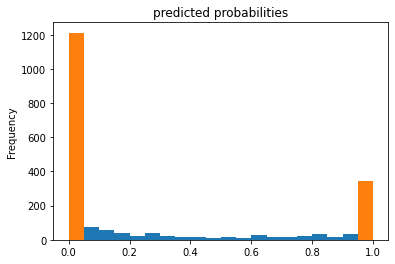

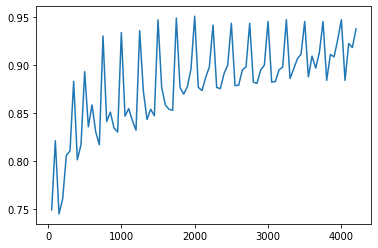

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.947047
accuracy_baseline          0.541752
auc                        0.988596
auc_precision_recall       0.980703
average_loss               0.137760
label/mean                 0.458248
loss                       0.217492
precision                  0.912863
prediction/mean            0.478826
recall                     0.977778
global_step             4250.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 21 on total: 311
0.9494152046783626
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


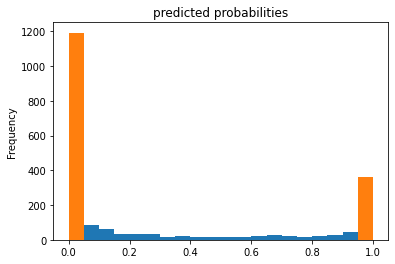

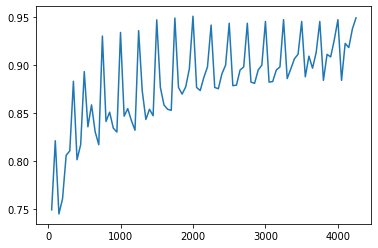

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.888421
accuracy_baseline          0.568421
auc                        0.963234
auc_precision_recall       0.936567
average_loss               0.254592
label/mean                 0.431579
loss                       0.388846
precision                  0.883838
prediction/mean            0.411004
recall                     0.853659
global_step             4300.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 23 on total: 311
0.8842366757000903
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


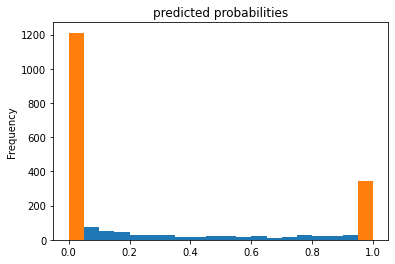

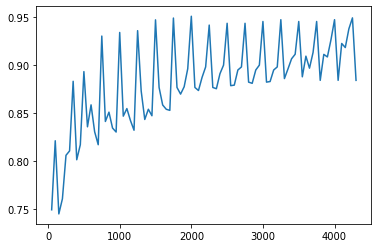

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.928131
accuracy_baseline          0.548255
auc                        0.982635
auc_precision_recall       0.976531
average_loss               0.172737
label/mean                 0.451745
loss                       0.270491
precision                  0.930233
prediction/mean            0.421129
recall                     0.909091
global_step             4350.000000
dtype: float64
WEIGHTED: 
D ERR: 4; R ERR: 15 on total: 311
0.926455566905005
       FIPS  Result
0     17059       0
1      6103       0
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


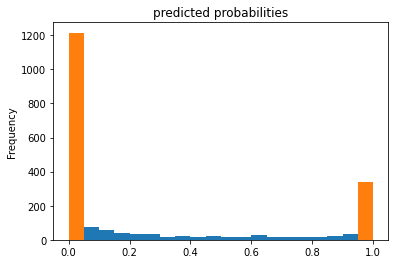

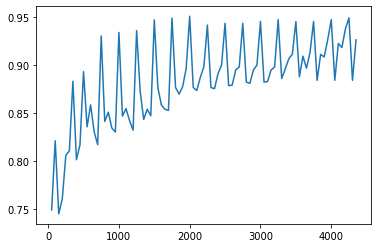

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.920388
accuracy_baseline          0.504854
auc                        0.976320
auc_precision_recall       0.974188
average_loss               0.191704
label/mean                 0.495146
loss                       0.317451
precision                  0.917969
prediction/mean            0.465573
recall                     0.921569
global_step             4400.000000
dtype: float64
WEIGHTED: 
D ERR: 4; R ERR: 21 on total: 311
0.9203996983408747
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


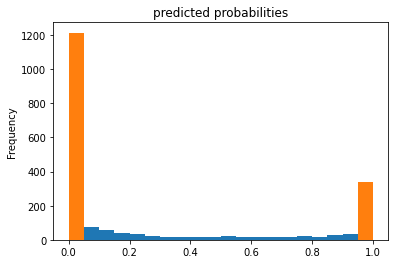

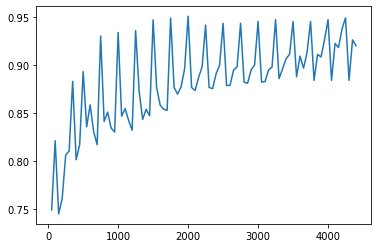

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.936345
accuracy_baseline          0.548255
auc                        0.974506
auc_precision_recall       0.966404
average_loss               0.196133
label/mean                 0.451745
loss                       0.307128
precision                  0.909091
prediction/mean            0.427242
recall                     0.954545
global_step             4450.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 21 on total: 311
0.937946884576098
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


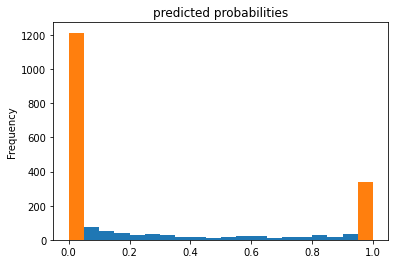

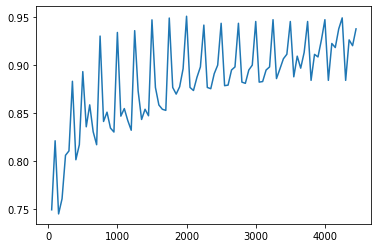

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.947047
accuracy_baseline          0.541752
auc                        0.988513
auc_precision_recall       0.980820
average_loss               0.135078
label/mean                 0.458248
loss                       0.213259
precision                  0.912863
prediction/mean            0.478240
recall                     0.977778
global_step             4500.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 21 on total: 311
0.9494152046783626
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


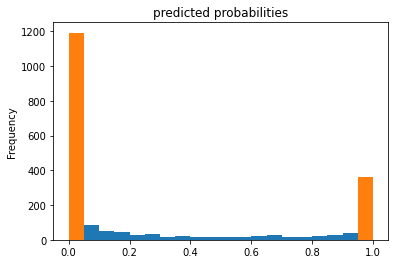

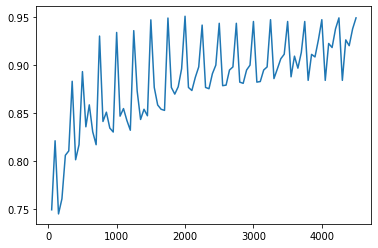

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.888421
accuracy_baseline          0.568421
auc                        0.964453
auc_precision_recall       0.938699
average_loss               0.251510
label/mean                 0.431579
loss                       0.384139
precision                  0.883838
prediction/mean            0.410864
recall                     0.853659
global_step             4550.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 23 on total: 311
0.8842366757000903
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


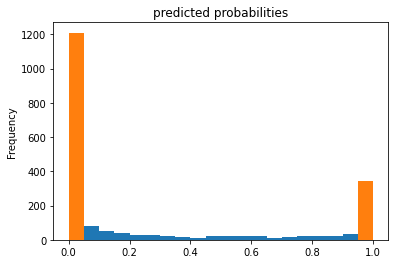

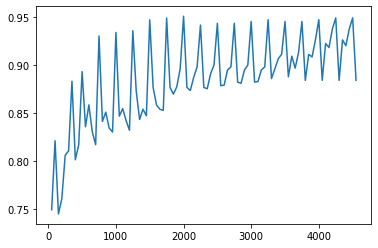

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


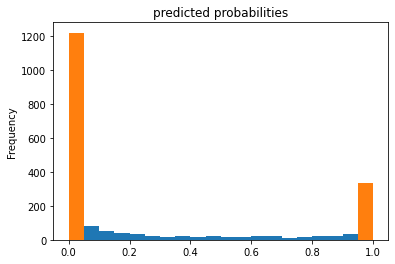

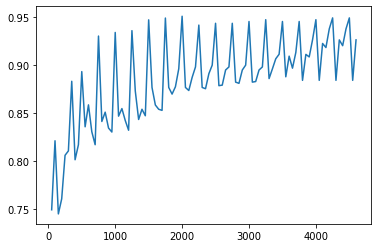

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


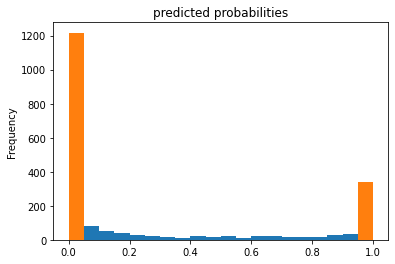

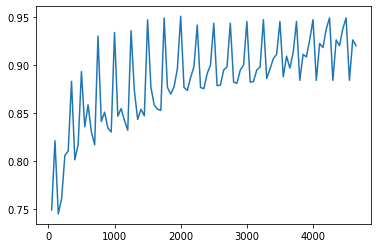

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.936345
accuracy_baseline          0.548255
auc                        0.975953
auc_precision_recall       0.968181
average_loss               0.189950
label/mean                 0.451745
loss                       0.297445
precision                  0.909091
prediction/mean            0.426900
recall                     0.954545
global_step             4700.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 21 on total: 311
0.937946884576098
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


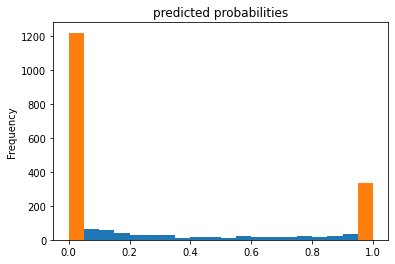

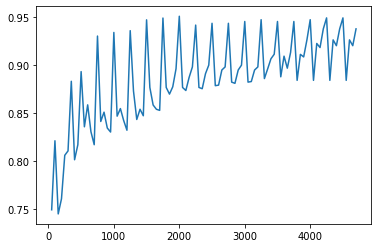

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.947047
accuracy_baseline          0.541752
auc                        0.988638
auc_precision_recall       0.981276
average_loss               0.132403
label/mean                 0.458248
loss                       0.209035
precision                  0.912863
prediction/mean            0.477784
recall                     0.977778
global_step             4750.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 21 on total: 311
0.9494152046783626
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


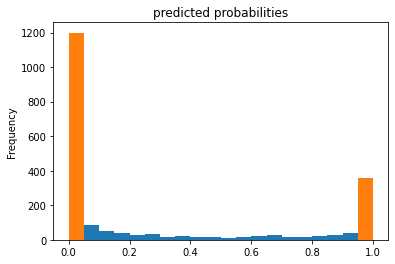

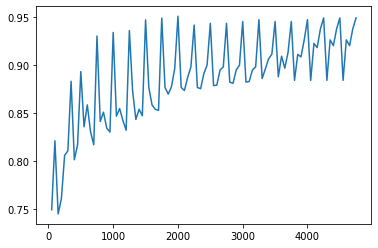

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.888421
accuracy_baseline          0.568421
auc                        0.964363
auc_precision_recall       0.938206
average_loss               0.250324
label/mean                 0.431579
loss                       0.382328
precision                  0.883838
prediction/mean            0.408768
recall                     0.853659
global_step             4800.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 23 on total: 311
0.8842366757000903
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


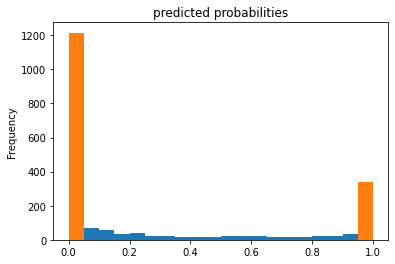

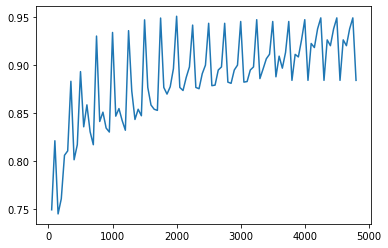

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


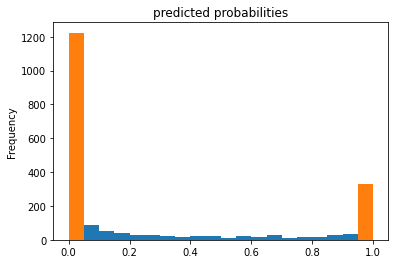

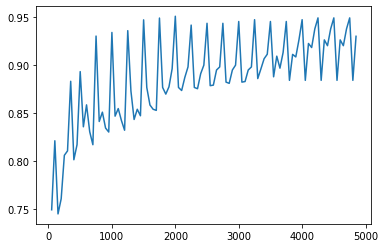

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


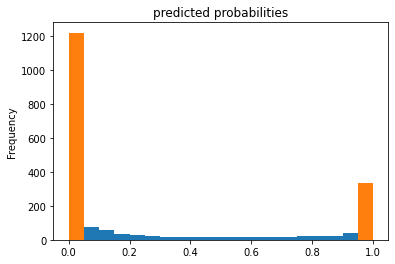

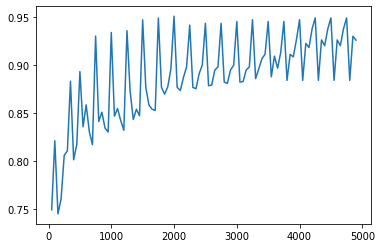

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.938398
accuracy_baseline          0.548255
auc                        0.977485
auc_precision_recall       0.970322
average_loss               0.184755
label/mean                 0.451745
loss                       0.289310
precision                  0.913043
prediction/mean            0.425062
recall                     0.954545
global_step             4950.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 20 on total: 311
0.9398195437521282
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


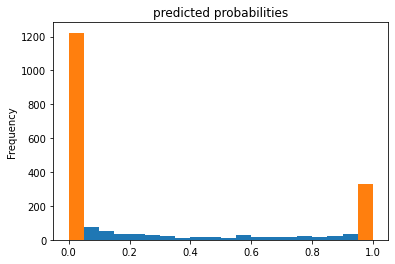

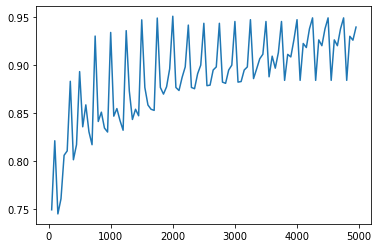

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.947047
accuracy_baseline          0.541752
auc                        0.989265
auc_precision_recall       0.981972
average_loss               0.129999
label/mean                 0.458248
loss                       0.205240
precision                  0.912863
prediction/mean            0.478511
recall                     0.977778
global_step             5000.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 21 on total: 311
0.9494152046783626
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


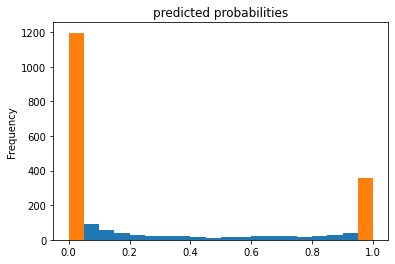

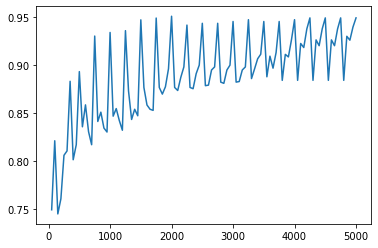

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.890526
accuracy_baseline          0.568421
auc                        0.964724
auc_precision_recall       0.938003
average_loss               0.247280
label/mean                 0.431579
loss                       0.377679
precision                  0.888325
prediction/mean            0.407111
recall                     0.853659
global_step             5050.000000
dtype: float64
WEIGHTED: 
D ERR: 6; R ERR: 22 on total: 311
0.8860885275519421
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


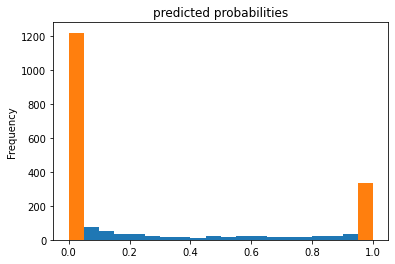

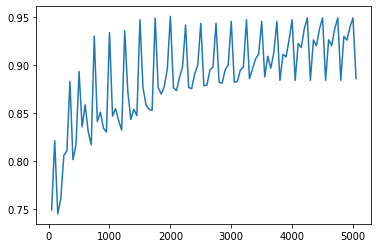

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.932238
accuracy_baseline          0.548255
auc                        0.987445
auc_precision_recall       0.982933
average_loss               0.150897
label/mean                 0.451745
loss                       0.236293
precision                  0.938967
prediction/mean            0.425972
recall                     0.909091
global_step             5100.000000
dtype: float64
WEIGHTED: 
D ERR: 4; R ERR: 13 on total: 311
0.9302008852570651
       FIPS  Result
0     17059       0
1      6103       0
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


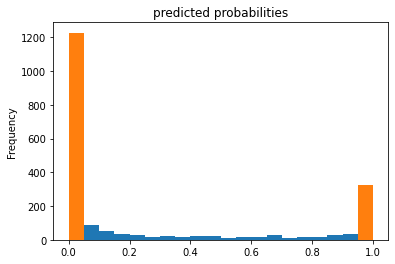

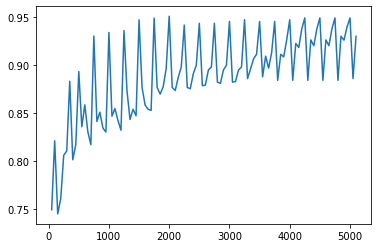

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

Length: 1555, dtype: float64
accuracy                   0.926214
accuracy_baseline          0.504854
auc                        0.980128
auc_precision_recall       0.978201
average_loss               0.178143
label/mean                 0.495146
loss                       0.294996
precision                  0.928854
prediction/mean            0.465099
recall                     0.921569
global_step             5150.000000
dtype: float64
WEIGHTED: 
D ERR: 4; R ERR: 18 on total: 311
0.9261689291101054
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


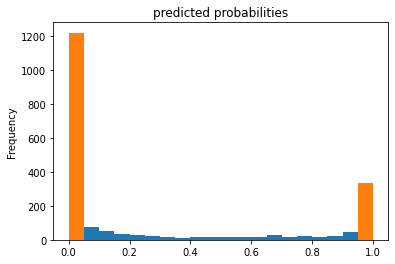

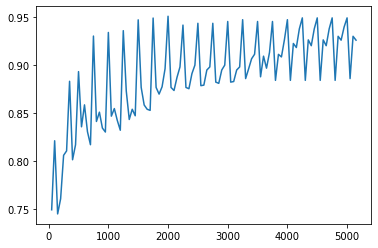

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


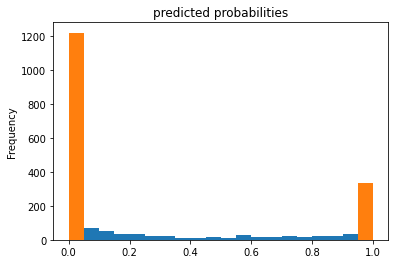

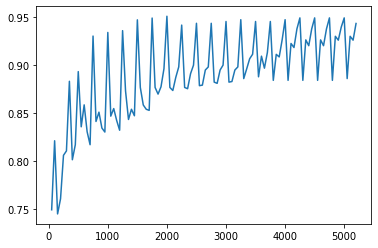

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


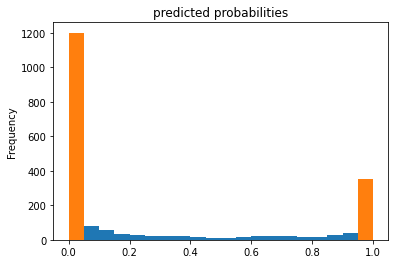

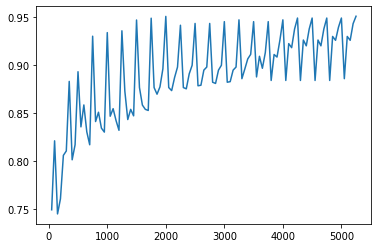

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.901053
accuracy_baseline          0.568421
auc                        0.965763
auc_precision_recall       0.938974
average_loss               0.243034
label/mean                 0.431579
loss                       0.371193
precision                  0.891089
prediction/mean            0.408415
recall                     0.878049
global_step             5300.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 22 on total: 311
0.8982836495031619
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


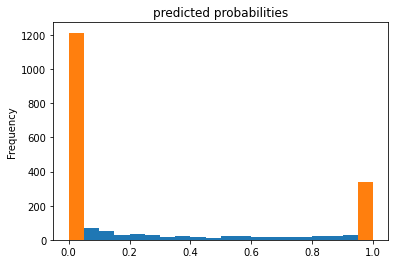

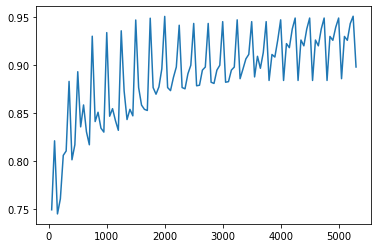

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.954825
accuracy_baseline          0.548255
auc                        0.988253
auc_precision_recall       0.983973
average_loss               0.142465
label/mean                 0.451745
loss                       0.223088
precision                  0.945946
prediction/mean            0.430498
recall                     0.954545
global_step             5350.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 12 on total: 311
0.9548008171603677
       FIPS  Result
0     17059       0
1      6103       0
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


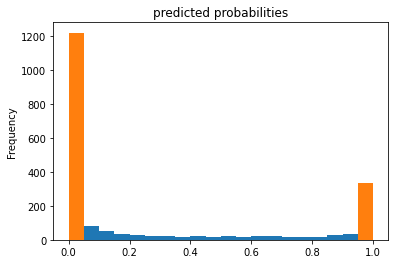

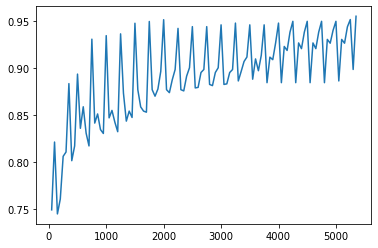

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.924272
accuracy_baseline          0.504854
auc                        0.980996
auc_precision_recall       0.979233
average_loss               0.174872
label/mean                 0.495146
loss                       0.289578
precision                  0.925197
prediction/mean            0.465130
recall                     0.921569
global_step             5400.000000
dtype: float64
WEIGHTED: 
D ERR: 4; R ERR: 19 on total: 311
0.9242458521870287
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


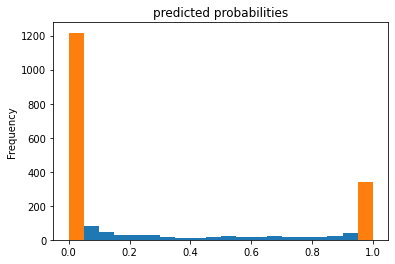

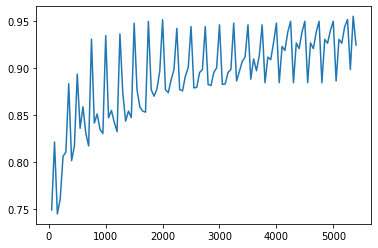

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


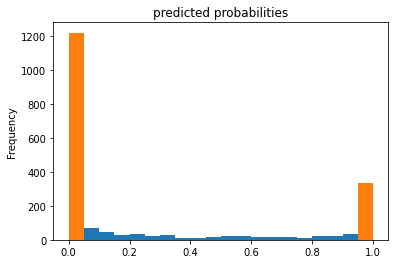

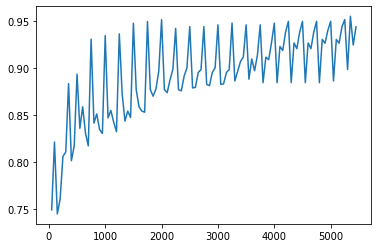

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.949084
accuracy_baseline          0.541752
auc                        0.989474
auc_precision_recall       0.982771
average_loss               0.126769
label/mean                 0.458248
loss                       0.200141
precision                  0.916667
prediction/mean            0.476994
recall                     0.977778
global_step             5500.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 20 on total: 311
0.9512949039264829
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


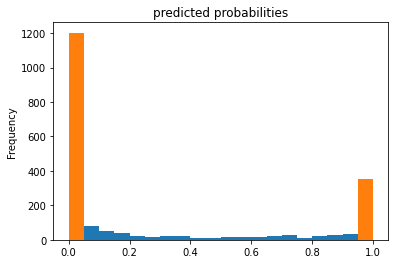

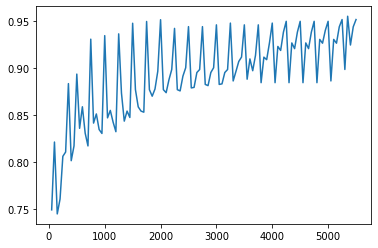

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.903158
accuracy_baseline          0.568421
auc                        0.966215
auc_precision_recall       0.939301
average_loss               0.240443
label/mean                 0.431579
loss                       0.367237
precision                  0.895522
prediction/mean            0.408464
recall                     0.878049
global_step             5550.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 21 on total: 311
0.9001355013550136
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


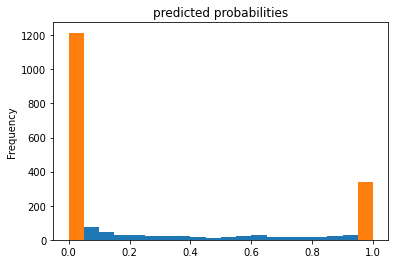

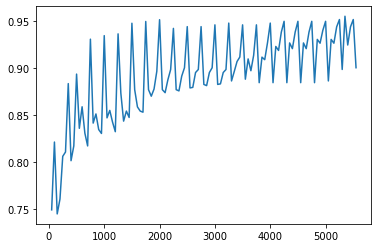

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.954825
accuracy_baseline          0.548255
auc                        0.989147
auc_precision_recall       0.985107
average_loss               0.136218
label/mean                 0.451745
loss                       0.213306
precision                  0.945946
prediction/mean            0.431992
recall                     0.954545
global_step             5600.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 12 on total: 311
0.9548008171603677
       FIPS  Result
0     17059       0
1      6103       0
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


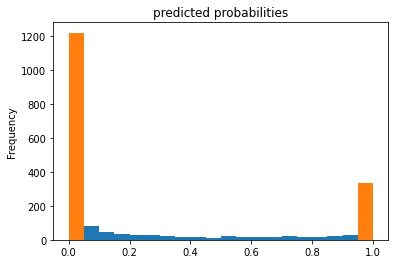

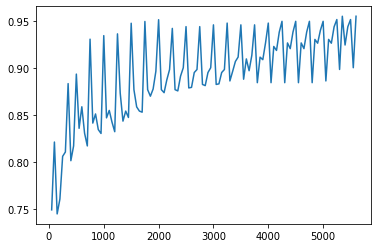

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

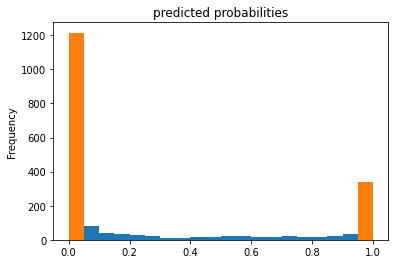

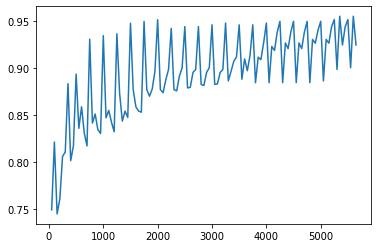

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.942505
accuracy_baseline          0.548255
auc                        0.981656
auc_precision_recall       0.975518
average_loss               0.169342
label/mean                 0.451745
loss                       0.265176
precision                  0.921053
prediction/mean            0.426825
recall                     0.954545
global_step             5700.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 18 on total: 311
0.9435648621041881
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


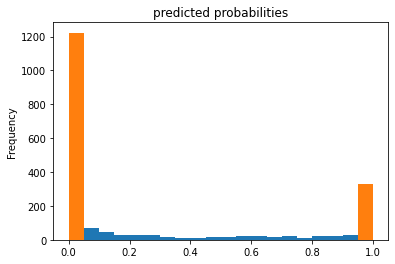

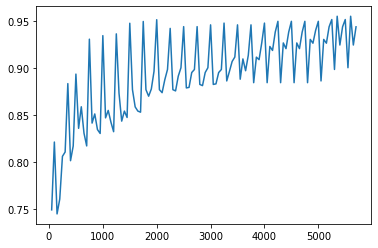

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.951120
accuracy_baseline          0.541752
auc                        0.989599
auc_precision_recall       0.983207
average_loss               0.124071
label/mean                 0.458248
loss                       0.195881
precision                  0.920502
prediction/mean            0.476471
recall                     0.977778
global_step             5750.000000
dtype: float64
WEIGHTED: 
D ERR: 1; R ERR: 19 on total: 311
0.9531746031746032
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


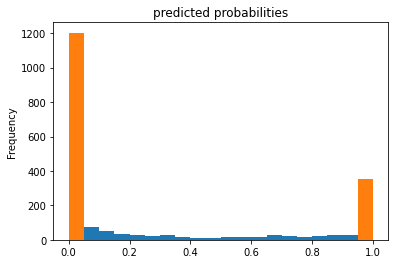

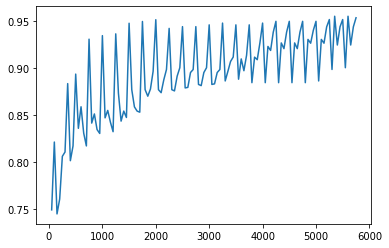

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.907368
accuracy_baseline          0.568421
auc                        0.967028
auc_precision_recall       0.940284
average_loss               0.234743
label/mean                 0.431579
loss                       0.358531
precision                  0.904523
prediction/mean            0.408025
recall                     0.878049
global_step             5800.000000
dtype: float64
WEIGHTED: 
D ERR: 5; R ERR: 19 on total: 311
0.9038392050587174
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


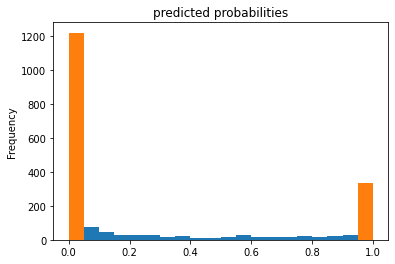

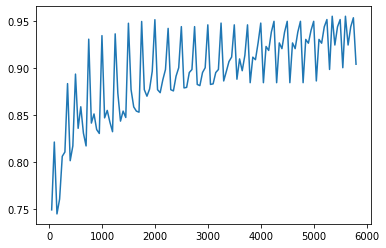

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


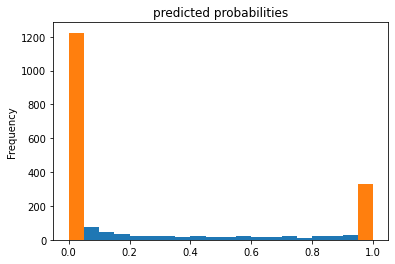

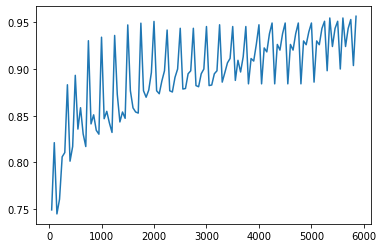

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

POST GRAPHS


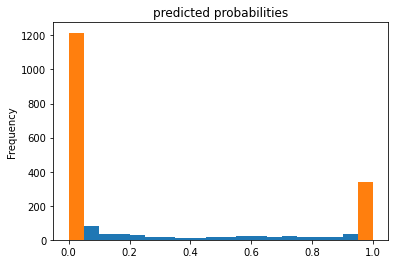

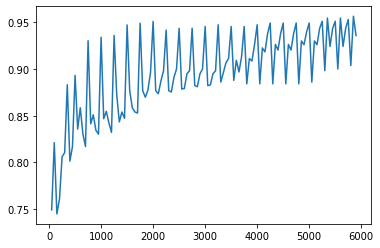

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

accuracy                   0.942505
accuracy_baseline          0.548255
auc                        0.982508
auc_precision_recall       0.976613
average_loss               0.165647
label/mean                 0.451745
loss                       0.259390
precision                  0.921053
prediction/mean            0.426739
recall                     0.954545
global_step             5950.000000
dtype: float64
WEIGHTED: 
D ERR: 2; R ERR: 18 on total: 311
0.9435648621041881
       FIPS  Result
0     17059       0
1      6103       1
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       1
1551  34035       1
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]
POST GRAPHS


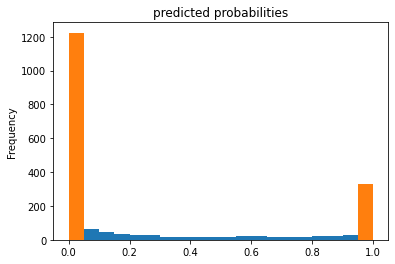

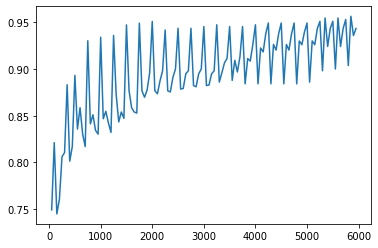

TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to th

In [ ]:


# print(dftrain.shape)
# print(y_train.shape)
# print(dfeval.shape)
# print(y_eval.shape)

# CATEGORICAL_COLUMNS = []
# NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']

CATEGORICAL_COLUMNS = []
CATEGORICAL_COLUMNS = ['StateCode']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']


NUMERIC_COLUMNS_2012 = []
NUMERIC_COLUMNS_DIFF = []

NUMERIC_COLUMNS_2012 = [x+'2012' for x in NUMERIC_COLUMNS]
NUMERIC_COLUMNS_DIFF = [x+'Diff' for x in NUMERIC_COLUMNS]

NUMERIC_COLUMNS += NUMERIC_COLUMNS_2012
# NUMERIC_COLUMNS += NUMERIC_COLUMNS_DIFF

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

# print(feature_columns)

# example = dict(dftrain.head(1))
# class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
# print('Feature value: "{}"'.format(example['class'].iloc[0]))
# print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
og_train_input_fn = make_input_fn(train_x, train_y, shuffle=False, n_epochs=1)
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
test_input_fn = make_input_fn(test_x, None, shuffle=False, n_epochs=1)

# KFOLD SPLITTING
trains = []
vals = []
k = 5
splitter = 1555//k
split_index = [splitter*i for i in range(k)]
back_idx = [splitter*(i+1) for i in range(k)]
back_idx[-1] = 1555
yvals = []
print(split_index)
print(back_idx)

train_x1 = train_x
train_y1 = train_y

for i in range(k):
    # dftrain = train_x.iloc[:split,:]
# y_train = train_y.iloc[:split]
    train_x = train_x1.copy()
    train_y = train_y1.copy()
    tdf = pd.concat([train_x.iloc[:split_index[i],:], train_x.iloc[back_idx[i]:,:]])
    ty = pd.concat([train_y.iloc[:split_index[i]], train_y.iloc[back_idx[i]:]])
    
    df = train_x.iloc[split_index[i]:back_idx[i],:]
    y = train_y.iloc[split_index[i]:back_idx[i]]
    
    print(tdf)
    print(ty)
    print(df)
    print(y)
    trains.append(make_input_fn(tdf, ty, shuffle = True))
    vals.append(make_input_fn(df,y,shuffle=False, n_epochs=1))
    yvals.append(y)

print(trains)
print(vals)
    
# linear_est = tf.estimator.LinearClassifier(feature_columns)

# # Train model.
# linear_est.train(train_input_fn, max_steps=100)

# # Evaluation.
# result = linear_est.evaluate(eval_input_fn)
# clear_output()
# print(pd.Series(result))

# # Since data fits into memory, use entire dataset per layer. It will be faster.
# # Above one batch is defined as the entire dataset.

# BOOSTED TREES
n_batches = 5
_max_depth = 8

weight_col = None
weight_col = 'Weight'
# est = tf.estimator.BoostedTreesRegressor(feature_columns,
#                                           n_batches_per_layer=n_batches, n_trees = 500, max_depth=_max_depth)


#     est = tf.estimator.BoostedTreesClassifier(feature_columns,
#                                               n_batches_per_layer=n_batches, n_trees = 1000, 
#                                               max_depth=_max_depth, weight_column = weight_col)

# DNN??
est = tf.estimator.DNNLinearCombinedClassifier(
    # wide settings
    linear_feature_columns=feature_columns,
#     linear_optimizer=tf.keras.optimizers.Ftrl(...),
    # deep settings
    linear_optimizer = 'Adam',
    dnn_optimizer = 'Adam',
    dnn_feature_columns=feature_columns,
#     dnn_activation_fn = tf.nn.sigmoid_cross_entropy_with_logits,    
    dnn_activation_fn = tf.nn.relu,
    dnn_hidden_units=[15],
    weight_column = weight_col,
    batch_norm = False)

_run = True
n = 0
i = -1
scores = [0 for i in range(k)]

accs = []
ns = []
while _run:
    incr = 50
    n += incr
    if n > 200*incr:
        break
    i += 1
    i = i%k
    
#     worst = np.argmin(scores)
#     print(worst)
#     i = worst
    
    train_input_fn = trains[i]
    eval_input_fn  = vals[i]

#     train_input_fn = og_train_input_fn
# #     eval_input_fn  = vals[i]

    # # The model will stop training once the specified number of trees is built, not
    # # based on the number of steps.
    print("TRAINING")
    est.train(train_input_fn, max_steps=n)
    ns.append(n)
    # Eval.
    print("EVAL")
    eval_pred_dicts = list(est.predict(eval_input_fn))
    result = est.evaluate(eval_input_fn)
#     print(result)
    
    print("TEST")
    pred_dicts = list(est.predict(test_input_fn))
    # pred_dicts = list(est.predict(og_train_input_fn))
    # print(pred_dicts)
    preds = None
    print(len(pred_dicts))
    print(pred_dicts[0])
    # print(pred_dicts)
    try:
        preds = pd.Series([pred['predictions'][0] for pred in pred_dicts])
        eval_preds = pd.Series([pred['predictions'][0] for pred in eval_pred_dicts])
    except:
        preds = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
        eval_preds = pd.Series([pred['probabilities'][1] for pred in eval_pred_dicts])

    print(preds)
    preds.plot(kind='hist', bins=20, title='predicted probabilities')

    submission = cpackage(preds, dfsample.copy(), thresh = 0.5)
    eval_submission = cthresh(eval_preds, thresh = 0.5)

    
    print(pd.Series(result))
    print("WEIGHTED: ")
    try:
        w_acc = weighted_accuracy(eval_submission, yvals[i])
        accs.append(w_acc)
    except:
        w_acc = .69
    scores[i] = w_acc
    print(w_acc)
    
    print(submission)
    submission.iloc[0:,1].plot(kind='hist', bins=20, title='predicted probabilities')
    print("POST GRAPHS")
    name = 'creative/submission2_r.csv'
    submission.to_csv(name ,index = False)
    submiss = pd.read_csv(name, sep=',', encoding='unicode_escape')
    
    plt.show()
#     _run = result["loss"] > .2
    plt.plot(ns,accs)
    plt.show()
    _run = w_acc < .98

# TODO

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

<h2>Part 5: Resources and Literature Used</h2><p>